In [1]:
import numpy as np
import secrets
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import itertools
from scipy.optimize import curve_fit
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [2]:
# Function cell

def generate_random_binary_string(length):
    binary_string = ''.join(np.random.choice(['0', '1'], size=length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}
    
    if n_tasks > np.power(2, len_taskcode):
        print("Error: n_tasks is too large")
        return False

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = np.random.choice(range(len_message), size=num_checks, replace=False).tolist()
            tasks_dict[binary_string] = integer_list

    return tasks_dict


def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

def generate_dataset_for_task(task_code, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = task_code
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# IS NOT USING BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y

In [5]:
# For later curve fitting
def sigmoid(x, L ,x0, k, b):
    # L is overll scale, x0 is x translation, b is y translation, k is width
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# For later curve fitting. Assumes that the accuracy goes between 0.5 and 1
def constrained_sigmoid(x, x0, k):
    y = 0.5 / (1 + np.exp(-k*(x-x0))) + 0.5
    return y

In [6]:
# Plotting sig params. Note that all of these curves are for ACCURACY. Probably unneeded.

def extract_params(params_list):
    params_list_flattened = params_list.flatten()
    x0 = np.empty(int(len(params_list_flattened) / 2))
    k = np.empty(int(len(params_list_flattened) / 2))
    for i in range(int(len(params_list_flattened) / 2)):
        x0[i] = params_list_flattened[2*i]
        k[i] = params_list_flattened[2*i + 1]
    return [x0, k]

len_message = 10


  0%|          | 0/30 [00:00<?, ?it/s]

Repeat: 0 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 1500 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 1600 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 1700 - Test Accuracy: 0.596666

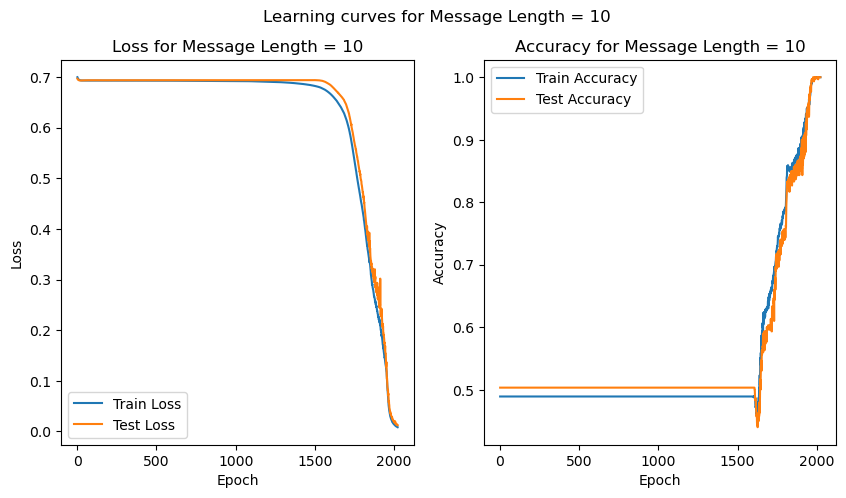

C:\Users\plogo\AppData\Local\Temp\ipykernel_21496\1718704704.py:9: RuntimeWarning: overflow encountered in exp
  y = 0.5 / (1 + np.exp(-k*(x-x0))) + 0.5
  3%|▎         | 1/30 [05:45<2:47:09, 345.84s/it]

Repeat: 1 - Epoch: 100 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.4866666666666667
Repeat: 1 - Epoch: 1700 - Test Accuracy: 0.486666

  7%|▋         | 2/30 [12:38<2:59:39, 385.00s/it]

Repeat: 2 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 1500 - Test Accuracy: 0.49333333333333335
Repeat: 2 - Epoch: 1600 - Test Accuracy: 0.58
Repeat: 2 - Epoch: 1700 - Test Accuracy: 0.61666

 10%|█         | 3/30 [17:42<2:36:41, 348.19s/it]

Repeat: 2 - Epoch: 1900 - Test Accuracy: 0.9733333333333334
Repeat: 3 - Epoch: 100 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 200 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 300 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 400 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 500 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 600 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 700 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 800 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 900 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 1000 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 1100 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 1200 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 1300 - Test Accuracy: 0.4866666666666667
Repeat: 3 - Epoch: 1400 - Test Accuracy: 0.4666666666666667
Repeat: 3 - Epoch: 1500 - Test Accuracy: 0.6833333333333333
Repeat: 3 - Epoch: 1600 - Test Accuracy: 0.83
Rep

 13%|█▎        | 4/30 [21:53<2:14:13, 309.76s/it]

Repeat: 4 - Epoch: 100 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 200 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 300 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 400 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 500 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 600 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 700 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 800 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 900 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1000 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1100 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1200 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1300 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1400 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1500 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1600 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1700 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1800 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1900 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 2000 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 2100 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 2200 - Test Accuracy: 0.

 17%|█▋        | 5/30 [27:55<2:16:56, 328.67s/it]

Repeat: 5 - Epoch: 100 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 200 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 300 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 400 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 500 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 600 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 700 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 800 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 900 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1000 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1100 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1200 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1300 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1400 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1500 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1600 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1700 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1800 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1900 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 2000 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 2100 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 2200 - Test Accuracy: 0.

 20%|██        | 6/30 [33:44<2:14:09, 335.41s/it]

Repeat: 6 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 1200 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 1300 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 1400 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 1500 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 1600 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 1700 - Test Ac

 23%|██▎       | 7/30 [40:14<2:15:28, 353.42s/it]

Repeat: 7 - Epoch: 100 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 200 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 300 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 400 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 500 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 600 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 700 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 800 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 900 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 1000 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 1100 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 1200 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 1300 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 1400 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 1500 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 1600 - Test Accuracy: 0.4866666666666667
Repeat: 7 - Epoch: 1700 - Test Accuracy: 0.486666

 27%|██▋       | 8/30 [45:25<2:04:35, 339.80s/it]

Repeat: 8 - Epoch: 100 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 200 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 300 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 400 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 500 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 600 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 700 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 800 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 900 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 1000 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 1100 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 1200 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 1300 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 1400 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 1500 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 1600 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 1700 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 1800 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 1900 - Test Accuracy: 0.48
Repeat: 8 - Epoch: 2000 - Test Accuracy: 0.4533333333333333
Repeat: 8 - Epoch: 2100 - Test Accuracy: 0.63
Repeat: 8 - Epoch: 2200 - Tes

 30%|███       | 9/30 [51:05<1:58:59, 339.98s/it]

Repeat: 9 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 1500 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 1600 - Test Accuracy: 0.5033333333333333
Repeat: 9 - Epoch: 1700 - Test Accuracy: 0.503333

 33%|███▎      | 10/30 [56:58<1:54:41, 344.10s/it]

Repeat: 10 - Epoch: 100 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 200 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 300 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 400 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 500 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 600 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 700 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 800 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 900 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 1000 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 1100 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 1200 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 1300 - Test Accuracy: 0.5133333333333333
Repeat: 10 - Epoch: 1400 - Test Accuracy: 0.7133333333333334
Repeat: 10 - Epoch: 1500 - Test Accuracy: 0.9966666666666667


 37%|███▋      | 11/30 [1:00:35<1:36:34, 304.98s/it]

Repeat: 11 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 1200 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 1300 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 1400 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 1500 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 1600 - Test Accuracy: 0.5266666666666666
Repeat: 11 - Epoch

 40%|████      | 12/30 [1:04:55<1:27:25, 291.41s/it]

Repeat: 12 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 1100 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 1200 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 1300 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 1400 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 1500 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 1600 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 1700 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 1800 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 1900 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 2000 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 2100 - Test Accuracy: 0.52
Repeat: 12 - Epoch: 22

 43%|████▎     | 13/30 [1:11:02<1:29:01, 314.20s/it]

Repeat: 13 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 1500 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 1600 - Test Accuracy: 0.5166666666666667
Repeat: 13 - Epoch: 1700 - Test A

 47%|████▋     | 14/30 [1:16:22<1:24:17, 316.09s/it]

Repeat: 14 - Epoch: 100 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 200 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 300 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 400 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 500 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 600 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 700 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 800 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 900 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1000 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1100 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1200 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1300 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1400 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1600 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoc

 50%|█████     | 15/30 [1:23:29<1:27:23, 349.58s/it]

Repeat: 15 - Epoch: 100 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 200 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 300 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 400 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 500 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 600 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 700 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 800 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 900 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1000 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1100 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1200 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1300 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1400 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 15 - Epoch: 1600 - Test Accuracy: 0.5033333333333333
Repeat: 15 - Epoch: 1700 - Test Accuracy: 0.92
Repeat: 15 - Epoch: 1800 - Test Accuracy: 0.9933333333333333


 53%|█████▎    | 16/30 [1:27:47<1:15:06, 321.90s/it]

Repeat: 16 - Epoch: 100 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 200 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 300 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 400 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 500 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 600 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 700 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 800 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 900 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 1000 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 1100 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 1200 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 1300 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 1400 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 1500 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 1600 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 1700 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 1800 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 1900 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 2000 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 2100 - Test Accuracy: 0.48
Repeat: 16 - Epoch: 22

 57%|█████▋    | 17/30 [1:35:17<1:18:04, 360.35s/it]

Repeat: 17 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 1500 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 1600 - Test Accuracy: 0.5033333333333333
Repeat: 17 - Epoch: 1700 - Test A

 60%|██████    | 18/30 [1:42:34<1:16:41, 383.49s/it]

Repeat: 18 - Epoch: 100 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 200 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 300 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 400 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 500 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 600 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 700 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 800 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 900 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 1000 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 1100 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 1200 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 1300 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 1400 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 1500 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 1600 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 1700 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 1800 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 1900 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 2000 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 2100 - Test Accuracy: 0.45
Repeat: 18 - Epoch: 22

 63%|██████▎   | 19/30 [1:50:50<1:16:29, 417.24s/it]

Repeat: 19 - Epoch: 100 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 600 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 700 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 800 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 900 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1000 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1100 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1200 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1300 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1400 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1500 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1600 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1700 - Test A

 67%|██████▋   | 20/30 [1:58:16<1:10:58, 425.81s/it]

Repeat: 20 - Epoch: 100 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 200 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 300 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 400 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 500 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 600 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 700 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 800 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 900 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 1000 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 1100 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 1200 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 1300 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 1400 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 1500 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 1600 - Test Accuracy: 0.5266666666666666
Repeat: 20 - Epoch: 1700 - Test A

 70%|███████   | 21/30 [2:03:24<58:35, 390.60s/it]  

Repeat: 21 - Epoch: 100 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 200 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 300 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 400 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 500 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 600 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 700 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 800 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 900 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 1000 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 1100 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 1200 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 1300 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 1400 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 1500 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 1600 - Test Accuracy: 0.4533333333333333
Repeat: 21 - Epoch: 1700 - Test A

 73%|███████▎  | 22/30 [2:08:28<48:35, 364.39s/it]

Repeat: 22 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1500 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1600 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoc

 77%|███████▋  | 23/30 [2:12:49<38:53, 333.40s/it]

Repeat: 23 - Epoch: 100 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 200 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 300 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 400 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 500 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 600 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 700 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 800 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 900 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 1000 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 1100 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 1200 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 1300 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 1400 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 1500 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 1600 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 1700 - Test A

 80%|████████  | 24/30 [2:20:24<36:59, 369.88s/it]

Repeat: 24 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1500 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1600 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1700 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1800 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1900 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 2000 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 2100 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 2200 - Test Accuracy: 0

 83%|████████▎ | 25/30 [2:27:28<32:10, 386.17s/it]

Repeat: 25 - Epoch: 100 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 200 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 300 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 400 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 500 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 600 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 700 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 800 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 900 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 1000 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 1100 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 1200 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 1300 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 1400 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 1500 - Test Accuracy: 0.54
Repeat: 25 - Epoch: 1600 - Test Accuracy: 0.5366666666666666
Repeat: 25 - Epoch: 1700 - Test Accuracy: 0.6566666666666666
Repeat: 25 - Epoch: 1800 - Test Accuracy: 0.71
Repeat: 25 - Epoch: 1900 - Test Accuracy: 0.8533333333333334
Repeat: 25 - Epoch: 2000 - Test Accuracy: 0.9933333333333333


 87%|████████▋ | 26/30 [2:32:17<23:47, 356.97s/it]

Repeat: 26 - Epoch: 100 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 200 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 300 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 400 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 500 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 600 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 700 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 800 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 900 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 1000 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 1100 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 1200 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 1300 - Test Accuracy: 0.44333333333333336
Repeat: 26 - Epoch: 1400 - Test Accuracy: 0.44666666666666666
Repeat: 26 - Epoch: 1500 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 1600 - Test Accuracy: 0.49666666666666665
Repeat: 26 - Epoch: 1700 - Test 

 90%|█████████ | 27/30 [2:36:42<16:28, 329.43s/it]

Repeat: 27 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 1500 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoch: 1600 - Test Accuracy: 0.49333333333333335
Repeat: 27 - Epoc

 93%|█████████▎| 28/30 [2:41:37<10:38, 319.13s/it]

Repeat: 28 - Epoch: 100 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 200 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 300 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 400 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 500 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 600 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 700 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 800 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 900 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 1000 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 1100 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 1200 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 1300 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 1400 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 1500 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 1600 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 1700 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 1800 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 1900 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 2000 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 2100 - Test Accuracy: 0.47
Repeat: 28 - Epoch: 22

 97%|█████████▋| 29/30 [2:47:48<05:34, 334.83s/it]

Repeat: 29 - Epoch: 100 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 200 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 300 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 400 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 500 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 600 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 700 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 800 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 900 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 1000 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 1100 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 1200 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 1300 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 1400 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 1500 - Test Accuracy: 0.5366666666666666
Repeat: 29 - Epoch: 1600 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1700 - Test A

100%|██████████| 30/30 [2:52:29<00:00, 344.99s/it]


len_message = 9


  0%|          | 0/30 [00:00<?, ?it/s]

Repeat: 0 - Epoch: 100 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 1000 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 1100 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 1200 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 1300 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 1400 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 1500 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 1600 - Test Accuracy: 0.44333333333333336
Repeat: 0 - Epoch: 1700 - Test Ac

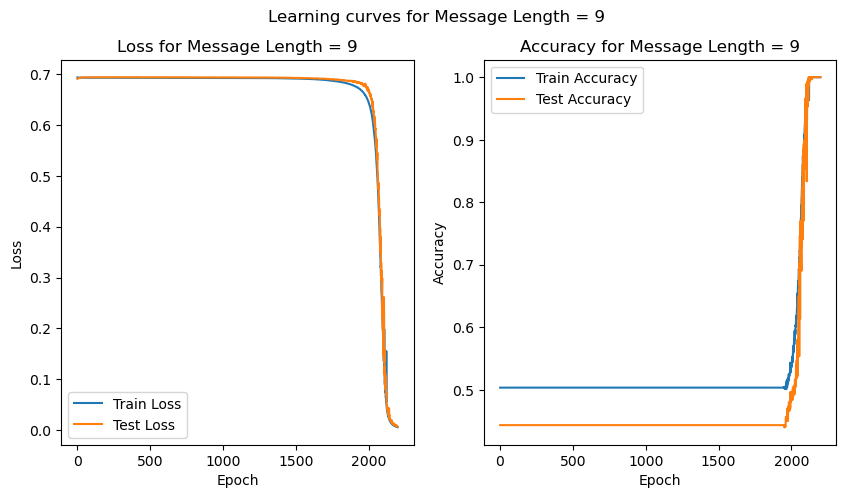

  3%|▎         | 1/30 [05:11<2:30:46, 311.96s/it]

Repeat: 1 - Epoch: 100 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.5533333333333333
Repeat: 1 - Epoch: 1700 - Test Accuracy: 0.553333

  7%|▋         | 2/30 [10:11<2:22:12, 304.74s/it]

Repeat: 2 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 1500 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 1600 - Test Accuracy: 0.5033333333333333
Repeat: 2 - Epoch: 1700 - Test Accuracy: 0.503333

 10%|█         | 3/30 [17:29<2:44:29, 365.55s/it]

Repeat: 3 - Epoch: 100 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 200 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 300 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 400 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 500 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 600 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 700 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 800 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 900 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 1000 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 1100 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 1200 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 1300 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 1400 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 1500 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 1600 - Test Accuracy: 0.5366666666666666
Repeat: 3 - Epoch: 1700 - Test Accuracy: 0.536666

 13%|█▎        | 4/30 [24:22<2:46:26, 384.10s/it]

Repeat: 4 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 4 - Epoch: 1700 - Test Accuracy: 0.63
Rep

 17%|█▋        | 5/30 [29:13<2:26:04, 350.59s/it]

Repeat: 5 - Epoch: 100 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 200 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 300 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 400 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 500 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 600 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 700 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 800 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 900 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1000 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1100 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1200 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1300 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1400 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1500 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1600 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1700 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1800 - Test Accuracy: 0.47
Repeat: 5 - Epoch: 1900 - Test Accuracy: 0.5033333333333333
Repeat: 5 - Epoch: 2000 - Test Accuracy: 0.74
Repeat: 5 - Epoch: 2100 - Test Accuracy: 0.97


 20%|██        | 6/30 [34:47<2:17:59, 344.97s/it]

Repeat: 6 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 1500 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 1600 - Test Accuracy: 0.49333333333333335
Repeat: 6 - Epoch: 1700 - Test Ac

 23%|██▎       | 7/30 [45:52<2:52:22, 449.67s/it]

Repeat: 7 - Epoch: 100 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 200 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 300 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 400 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 500 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 600 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 700 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 800 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 900 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 1000 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 1100 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 1200 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 1300 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 1400 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 1500 - Test Accuracy: 0.5333333333333333
Repeat: 7 - Epoch: 1600 - Test Accuracy: 0.57
Repeat: 7 - Epoch: 1700 - Test Accuracy: 0.63
Repeat: 7 - Epoch

 27%|██▋       | 8/30 [51:07<2:29:11, 406.91s/it]

Repeat: 8 - Epoch: 100 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 200 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 300 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 400 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 500 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 600 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 700 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 800 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 900 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 1000 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 1100 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 1200 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 1300 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 1400 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 1500 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 1600 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 1700 - Test Accuracy: 0.533333

 30%|███       | 9/30 [56:57<2:16:09, 389.04s/it]

Repeat: 9 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 1500 - Test Accuracy: 0.5166666666666667
Repeat: 9 - Epoch: 1600 - Test Accuracy: 0.68
Repeat: 9 - Epoch: 1700 - Test Accuracy: 1.0


 33%|███▎      | 10/30 [1:01:19<1:56:36, 349.84s/it]

Repeat: 10 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 1100 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 1200 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 1300 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 1400 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 1500 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 1600 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 1700 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 1800 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 1900 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 2000 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 2100 - Test Accuracy: 0.52
Repeat: 10 - Epoch: 22

 37%|███▋      | 11/30 [1:07:39<1:53:41, 359.01s/it]

Repeat: 11 - Epoch: 100 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 200 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 300 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 400 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 500 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 600 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 700 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 800 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 900 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 1000 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 1100 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 1200 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 1300 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 1400 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 1500 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 1600 - Test Accuracy: 0.5333333333333333
Repeat: 11 - Epoch: 1700 - Test A

 40%|████      | 12/30 [1:13:17<1:45:44, 352.47s/it]

Repeat: 12 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 12 - Epoch: 1700 - Test A

 43%|████▎     | 13/30 [1:19:33<1:41:56, 359.78s/it]

Repeat: 13 - Epoch: 100 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 200 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 900 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 1000 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 1100 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 1200 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 1300 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 1400 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 1500 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoch: 1600 - Test Accuracy: 0.44666666666666666
Repeat: 13 - Epoc

 47%|████▋     | 14/30 [1:25:07<1:33:52, 352.01s/it]

Repeat: 14 - Epoch: 100 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 200 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 300 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 400 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 500 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 600 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 700 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 800 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 900 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 1000 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 1100 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 1200 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 1300 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 1400 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 1500 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 1600 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 1700 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 1800 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 1900 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 2000 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 2100 - Test Accuracy: 0.55
Repeat: 14 - Epoch: 22

 50%|█████     | 15/30 [1:33:37<1:39:54, 399.65s/it]

Repeat: 15 - Epoch: 100 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 200 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 300 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 400 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 500 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 600 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 700 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 800 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 900 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 1000 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 1100 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 1200 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 1300 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 1400 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 1500 - Test Accuracy: 0.4666666666666667
Repeat: 15 - Epoch: 1600 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1700 - Test Accuracy: 0.51


 53%|█████▎    | 16/30 [1:38:55<1:27:32, 375.15s/it]

Repeat: 16 - Epoch: 100 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 200 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 300 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 400 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 500 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 600 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 700 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 800 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 900 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 1000 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 1100 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 1200 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 1300 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 1400 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 1500 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 1600 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 1700 - Test A

 57%|█████▋    | 17/30 [1:44:55<1:20:15, 370.44s/it]

Repeat: 17 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 1100 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 1200 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 1300 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 1400 - Test Accuracy: 0.4766666666666667
Repeat: 17 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 17 - Epoch: 1600 - Test Accuracy: 0.44333333333333336
Repeat: 17 - Epoch: 1700 - Test

 60%|██████    | 18/30 [1:50:21<1:11:24, 357.02s/it]

Repeat: 18 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 1100 - Test Accuracy: 0.52
Repeat: 18 - Epoch: 1200 - Test Accuracy: 0.54
Repeat: 18 - Epoch: 1300 - Test Accuracy: 0.5966666666666667
Repeat: 18 - Epoch: 1400 - Test Accuracy: 0.66
Repeat: 18 - Epoch: 1500 - Test Accuracy: 0.8866666666666667
Repeat: 18 - Epoch: 1600 - Test Accuracy: 0.97


 63%|██████▎   | 19/30 [1:55:12<1:01:49, 337.27s/it]

Repeat: 19 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 1400 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 1500 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 1600 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 1700 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 1800 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 1900 - Test Accuracy: 0.5
Repeat: 19 - Epoch: 2000 - Test Accuracy: 0.55
Repeat: 19 - Epoch: 2100 - Test Accuracy: 0.5766666666666667
Repeat: 19 - Epoch: 2200 - 

 67%|██████▋   | 20/30 [2:02:25<1:00:58, 365.87s/it]

Repeat: 20 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 20 - Epoch: 1700 - Test A

 70%|███████   | 21/30 [2:10:53<1:01:18, 408.77s/it]

Repeat: 21 - Epoch: 100 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 200 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 300 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 400 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 500 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 600 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 700 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 800 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 900 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 1000 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 1100 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 1200 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 1300 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 1400 - Test Accuracy: 0.4633333333333333
Repeat: 21 - Epoch: 1500 - Test Accuracy: 0.5533333333333333
Repeat: 21 - Epoch: 1600 - Test Accuracy: 0.6133333333333333
Repeat: 21 - Epoch: 1700 - Test A

 73%|███████▎  | 22/30 [2:15:34<49:22, 370.34s/it]  

Repeat: 22 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 1500 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 1600 - Test Accuracy: 0.5166666666666667
Repeat: 22 - Epoch: 1700 - Test A

 77%|███████▋  | 23/30 [2:25:31<51:08, 438.30s/it]

Repeat: 23 - Epoch: 100 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 200 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 300 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 400 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 500 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 600 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 700 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 800 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 900 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 1000 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 1100 - Test Accuracy: 0.44
Repeat: 23 - Epoch: 1200 - Test Accuracy: 0.5233333333333333
Repeat: 23 - Epoch: 1300 - Test Accuracy: 0.79
Repeat: 23 - Epoch: 1400 - Test Accuracy: 1.0


 80%|████████  | 24/30 [2:29:00<36:57, 369.56s/it]

Repeat: 24 - Epoch: 100 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 200 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.51
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.7866666666666666
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.8433333333333334
Repeat: 24 - Epoch: 1500 - Test Accuracy: 0.9166666666666666


 83%|████████▎ | 25/30 [2:33:27<28:14, 338.86s/it]

Repeat: 25 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 1200 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 1300 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 1400 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 1500 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 1600 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoc

 87%|████████▋ | 26/30 [2:41:33<25:31, 382.88s/it]

Repeat: 26 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 26 - Epoch: 1500 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1600 - Test Accuracy: 0.5133333333333333
Repeat: 26 - Epoch: 1700 - Test Accuracy: 0.5233

 90%|█████████ | 27/30 [2:47:19<18:35, 371.77s/it]

Repeat: 27 - Epoch: 100 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 1000 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 1100 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 1200 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 1300 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 1400 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 1500 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 1600 - Test Accuracy: 0.5366666666666666
Repeat: 27 - Epoch: 1700 - Test A

 93%|█████████▎| 28/30 [2:58:38<15:27, 463.99s/it]

Repeat: 28 - Epoch: 100 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 200 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 300 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 400 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 500 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 600 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 700 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 800 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 900 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 1000 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 1100 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 1200 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 1300 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 1400 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 1500 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 1600 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 1700 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 1800 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 1900 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 2000 - Test Accuracy: 0.55
Repeat: 28 - Epoch: 2100 - Test Accuracy: 0.5533333333333333
Repeat: 

 97%|█████████▋| 29/30 [3:05:35<07:29, 449.99s/it]

Repeat: 29 - Epoch: 100 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 200 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 300 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 400 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 500 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 600 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 700 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 800 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 900 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 1000 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 1100 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 1200 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 1300 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 1400 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 1500 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 1600 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 1700 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 1800 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 1900 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 2000 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 2100 - Test Accuracy: 0.6
Repeat: 29 - Epoch: 2200 - Test Accuracy: 0

100%|██████████| 30/30 [3:12:47<00:00, 385.58s/it]


len_message = 8


  0%|          | 0/30 [00:00<?, ?it/s]

Repeat: 0 - Epoch: 100 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 1000 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 1100 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 1200 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 1300 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 1400 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 1500 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 1600 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 1700 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 1800 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 1900 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 2000 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 2100 - Test Accuracy: 0.54
Repeat: 0 - Epoch: 2200 - Test Accuracy: 0.

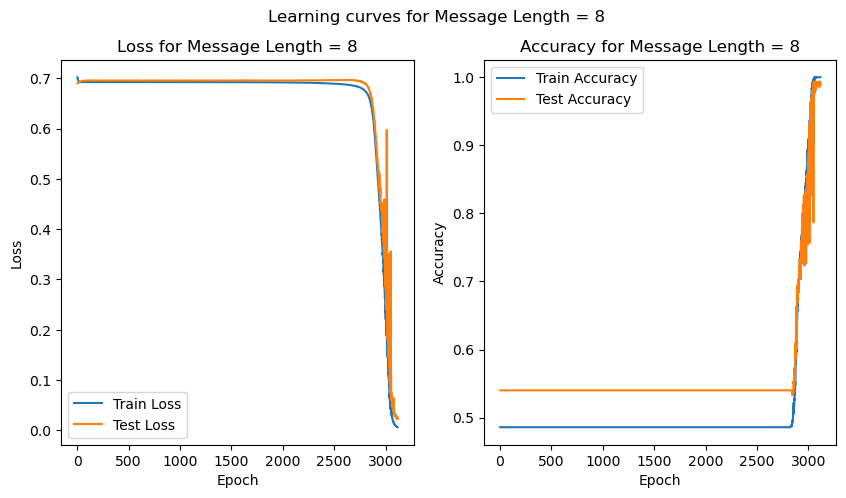

  3%|▎         | 1/30 [09:15<4:28:29, 555.52s/it]

Repeat: 1 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1700 - Test Accuracy: 0.516666

  7%|▋         | 2/30 [15:18<3:26:26, 442.38s/it]

Repeat: 2 - Epoch: 100 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 200 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 300 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 400 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 500 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 600 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 700 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 800 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 900 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 1000 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 1100 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 1200 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 1300 - Test Accuracy: 0.45666666666666667
Repeat: 2 - Epoch: 1400 - Test Accuracy: 0.5233333333333333
Repeat: 2 - Epoch: 1500 - Test Accuracy: 0.7066666666666667
Repeat: 2 - Epoch: 1600 - Test Accuracy: 1.0


 10%|█         | 3/30 [20:09<2:48:00, 373.35s/it]

Repeat: 3 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 3 - Epoch: 1700 - Test Accuracy: 0.506666

 13%|█▎        | 4/30 [26:40<2:44:48, 380.33s/it]

Repeat: 4 - Epoch: 100 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 200 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 300 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 400 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 500 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 600 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 700 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 800 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 900 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 1000 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 1100 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 1200 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 1300 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 1400 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 1500 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 1600 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 1700 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 1800 - Test Accuracy: 0.45
Repeat: 4 - Epoch: 1900 - Test Accuracy: 0.6766666666666666
Repeat: 4 - Epoch: 2000 - Test Accuracy: 1.0


 17%|█▋        | 5/30 [32:42<2:35:40, 373.63s/it]

Repeat: 5 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 1100 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 1200 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 1300 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 1400 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 1500 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 1600 - Test Accuracy: 0.4766666666666667
Repeat: 5 - Epoch: 1700 - Test Accuracy: 0.476666

 20%|██        | 6/30 [38:35<2:26:41, 366.72s/it]

Repeat: 6 - Epoch: 100 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 200 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 300 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 400 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 500 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 600 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 700 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 800 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 900 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 1000 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 1100 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 1200 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 1300 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 1400 - Test Accuracy: 0.56
Repeat: 6 - Epoch: 1500 - Test Accuracy: 0.5833333333333334
Repeat: 6 - Epoch: 1600 - Test Accuracy: 0.65
Repeat: 6 - Epoch: 1700 - Test Accuracy: 0.7233333333333334
Repeat: 6 - Epoch: 1800 - Test Accuracy: 0.8533333333333334
Repeat: 6 - Epoch: 1900 - Test Accuracy: 0.9666666666666667


 23%|██▎       | 7/30 [44:23<2:18:06, 360.30s/it]

Repeat: 7 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1500 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1600 - Test Accuracy: 0.5
Repeat: 7 - Epoch: 1700 - Test Accuracy: 0.5766666666666667
Repe

 27%|██▋       | 8/30 [50:13<2:10:56, 357.11s/it]

Repeat: 8 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 1500 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 1600 - Test Accuracy: 0.5033333333333333
Repeat: 8 - Epoch: 1700 - Test Accuracy: 0.503333

 30%|███       | 9/30 [1:01:20<2:38:56, 454.11s/it]

Repeat: 9 - Epoch: 100 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 200 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 300 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 400 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 500 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 600 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 700 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 800 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 900 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 1000 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 1100 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 1200 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 1300 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 1400 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 1500 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 1600 - Test Accuracy: 0.4633333333333333
Repeat: 9 - Epoch: 1700 - Test Accuracy: 0.463333

 33%|███▎      | 10/30 [1:10:35<2:41:45, 485.29s/it]

Repeat: 10 - Epoch: 100 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 200 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 300 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 400 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 500 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 600 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 700 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 800 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 900 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 1000 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 1100 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 1200 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 1300 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 1400 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 1500 - Test Accuracy: 0.5366666666666666
Repeat: 10 - Epoch: 1600 - Test Accuracy: 0.54
Repeat: 10 - Epoch: 1700 - Test Accuracy: 0.716

 37%|███▋      | 11/30 [1:16:26<2:20:39, 444.16s/it]

Repeat: 11 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 1500 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoch: 1600 - Test Accuracy: 0.49333333333333335
Repeat: 11 - Epoc

 40%|████      | 12/30 [1:23:42<2:12:27, 441.52s/it]

Repeat: 12 - Epoch: 100 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 200 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 300 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 400 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 500 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 600 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 700 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 800 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 900 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 1000 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 1100 - Test Accuracy: 0.54
Repeat: 12 - Epoch: 1200 - Test Accuracy: 0.5366666666666666
Repeat: 12 - Epoch: 1300 - Test Accuracy: 0.6933333333333334
Repeat: 12 - Epoch: 1400 - Test Accuracy: 0.7766666666666666
Repeat: 12 - Epoch: 1500 - Test Accuracy: 1.0


 43%|████▎     | 13/30 [1:28:38<1:52:35, 397.37s/it]

Repeat: 13 - Epoch: 100 - Test Accuracy: 0.5266666666666666
Repeat: 13 - Epoch: 200 - Test Accuracy: 0.5266666666666666
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.5266666666666666
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.5266666666666666
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.5266666666666666
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.5266666666666666
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.5266666666666666
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.5266666666666666
Repeat: 13 - Epoch: 900 - Test Accuracy: 0.5266666666666666
Repeat: 13 - Epoch: 1000 - Test Accuracy: 0.5266666666666666
Repeat: 13 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 13 - Epoch: 1200 - Test Accuracy: 0.7266666666666667
Repeat: 13 - Epoch: 1300 - Test Accuracy: 0.9133333333333333
Repeat: 13 - Epoch: 1400 - Test Accuracy: 1.0


 47%|████▋     | 14/30 [1:32:53<1:34:33, 354.61s/it]

Repeat: 14 - Epoch: 100 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 200 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 300 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 400 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 500 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 600 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 700 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 800 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 900 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1000 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1100 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1200 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1300 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1400 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoch: 1600 - Test Accuracy: 0.47333333333333333
Repeat: 14 - Epoc

 50%|█████     | 15/30 [1:40:52<1:37:57, 391.86s/it]

Repeat: 15 - Epoch: 100 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 200 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 300 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 400 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 500 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 600 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 700 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 800 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 900 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1000 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1100 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1200 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1300 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1400 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1500 - Test Accuracy: 0.46
Repeat: 15 - Epoch: 1600 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 1700 - Test Accuracy: 0.5333333333333333
Repeat: 15 - Epoch: 1800 - Test Accuracy: 0.6633333333333333
Repeat: 15 - Epoch: 1900 - Test Accuracy: 0.8966666666666666


 53%|█████▎    | 16/30 [1:46:47<1:28:50, 380.78s/it]

Repeat: 16 - Epoch: 100 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 200 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 300 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 400 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 500 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 600 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 700 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 800 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 900 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 1000 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 1100 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 1200 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 1300 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 1400 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 1500 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 1600 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 1700 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 1800 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 1900 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 2000 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 2100 - Test Accuracy: 0.47
Repeat: 16 - Epoch: 22

 57%|█████▋    | 17/30 [1:54:32<1:28:02, 406.37s/it]

Repeat: 17 - Epoch: 100 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 200 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 300 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 400 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 500 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 600 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 700 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 800 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 900 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 1000 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 1100 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 1200 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 1300 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 1400 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 1500 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 1600 - Test Accuracy: 0.5233333333333333
Repeat: 17 - Epoch: 1700 - Test A

 60%|██████    | 18/30 [2:01:53<1:23:20, 416.72s/it]

Repeat: 18 - Epoch: 100 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 200 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 300 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 400 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 500 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 600 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 700 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 800 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 900 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 1000 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 1100 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 1200 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 1300 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 1400 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 1500 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 1600 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 1700 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 1800 - Test Accuracy: 0.53
Repeat: 18 - Epoch: 1900 - Test Accuracy: 0.5233333333333333
Repeat: 18 - Epoch: 2000 - Test Accuracy: 0.5733333333333334
Repeat: 18 - Epoch: 2100 - Test Accuracy:

 63%|██████▎   | 19/30 [2:08:22<1:14:51, 408.28s/it]

Repeat: 19 - Epoch: 100 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 600 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 700 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 800 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 900 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1000 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1100 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1200 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1300 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1400 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1500 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1600 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1700 - Test A

 67%|██████▋   | 20/30 [2:16:26<1:11:51, 431.16s/it]

Repeat: 20 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 1000 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 1100 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 1200 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 1300 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 1400 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 1500 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 1600 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoc

 70%|███████   | 21/30 [2:23:42<1:04:51, 432.39s/it]

Repeat: 21 - Epoch: 100 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 200 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 300 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 400 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 500 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 600 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 700 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 800 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 900 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 1000 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 1100 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 1200 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 1300 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 1400 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 1500 - Test Accuracy: 0.5266666666666666
Repeat: 21 - Epoch: 1600 - Test Accuracy: 0.5033333333333333
Repeat: 21 - Epoch: 1700 - Test A

 73%|███████▎  | 22/30 [2:29:10<53:29, 401.14s/it]  

Repeat: 22 - Epoch: 100 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 200 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 300 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 400 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 500 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 600 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 700 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 800 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 900 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 1000 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 1100 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 1200 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 1300 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 1400 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 1500 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 1600 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 1700 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 1800 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 1900 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 2000 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 2100 - Test Accuracy: 0.48
Repeat: 22 - Epoch: 22

 77%|███████▋  | 23/30 [2:38:04<51:26, 440.92s/it]

Repeat: 23 - Epoch: 100 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 200 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 300 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 400 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 900 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 1000 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 1100 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 1200 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 1300 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 1400 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 1500 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 1600 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 1700 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 1800 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 1900 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 2000 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 2100 - Test Accuracy: 0.51
Repeat: 23 - Epoch: 22

 80%|████████  | 24/30 [2:45:54<44:58, 449.80s/it]

Repeat: 24 - Epoch: 100 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 200 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 1500 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 1600 - Test Accuracy: 0.5133333333333333
Repeat: 24 - Epoch: 1700 - Test A

 83%|████████▎ | 25/30 [2:52:49<36:36, 439.38s/it]

Repeat: 25 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1500 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1600 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1700 - Test A

 87%|████████▋ | 26/30 [3:00:41<29:56, 449.08s/it]

Repeat: 26 - Epoch: 100 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 200 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 300 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 400 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 500 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 600 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 700 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 800 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 900 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 1000 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 1100 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 1200 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 1300 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 1400 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 1500 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 1600 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 1700 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 1800 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 1900 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 2000 - Test Accuracy: 0.53
Repeat: 26 - Epoch: 2100 - Test Accuracy: 0.5166666666666667
Repeat: 

 90%|█████████ | 27/30 [3:07:45<22:04, 441.61s/it]

Repeat: 27 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 1100 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 1200 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 1300 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 1400 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 1500 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 1600 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 1700 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 1800 - Test Accuracy: 0.5766666666666667
Repeat: 27 - Epoch: 1900 - Test Accuracy: 0.73
Repeat: 27 - Epoch: 2000 - Test Accuracy: 0.9333333333333333


 93%|█████████▎| 28/30 [3:13:53<13:58, 419.40s/it]

Repeat: 28 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 1400 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 1500 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 1600 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 1700 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 1800 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 1900 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 2000 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 2100 - Test Accuracy: 0.5
Repeat: 28 - Epoch: 2200 - Test Accuracy: 0

 97%|█████████▋| 29/30 [3:20:39<06:55, 415.45s/it]

Repeat: 29 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1500 - Test Accuracy: 0.49666666666666665
Repeat: 29 - Epoch: 1600 - Test Accuracy: 0.5333333333333333
Repeat: 29 - Epoch

100%|██████████| 30/30 [3:25:57<00:00, 411.92s/it]


len_message = 7


  0%|          | 0/30 [00:00<?, ?it/s]

Repeat: 0 - Epoch: 100 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 1000 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 1100 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 1200 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 1300 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 1400 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 1500 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 1600 - Test Accuracy: 0.45666666666666667
Repeat: 0 - Epoch: 1700 - Test Ac

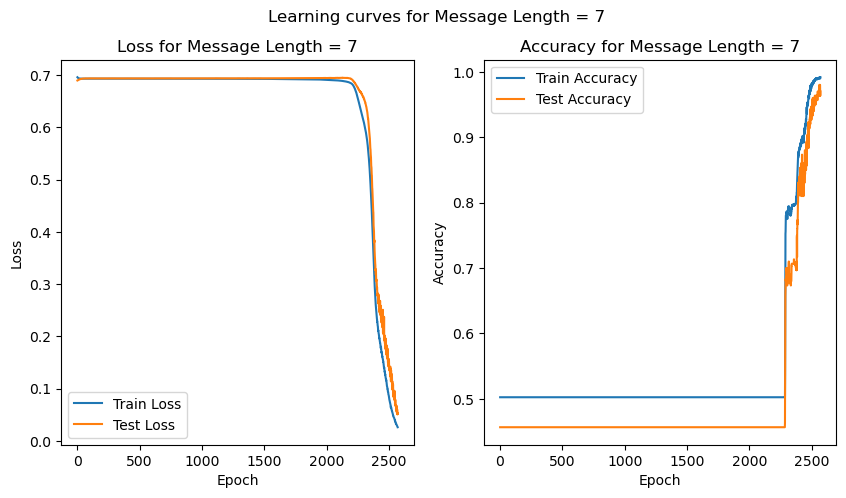

  3%|▎         | 1/30 [07:36<3:40:48, 456.85s/it]

Repeat: 1 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 1700 - Test Accuracy: 0.92333

  7%|▋         | 2/30 [12:49<2:53:37, 372.06s/it]

Repeat: 2 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 1000 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 1100 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 1200 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 1300 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 1400 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 1500 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 1600 - Test Accuracy: 0.48333333333333334
Repeat: 2 - Epoch: 1700 - Test Ac

 10%|█         | 3/30 [18:55<2:46:10, 369.29s/it]

Repeat: 3 - Epoch: 100 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 200 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 300 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 400 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 900 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 1000 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 1100 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 1200 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 1300 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 1400 - Test Accuracy: 0.51
Repeat: 3 - Epoch: 1500 - Test Accuracy: 0.8033333333333333
Repeat: 3 - Epoch: 1600 - Test Accuracy: 0.84
Repeat: 3 - Epoch: 1700 - Test Accuracy: 0.9766666666666667


 13%|█▎        | 4/30 [23:54<2:28:01, 341.59s/it]

Repeat: 4 - Epoch: 100 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 200 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 300 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 400 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 500 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 600 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 700 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 800 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 900 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 1000 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 1100 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 1200 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 1300 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 1400 - Test Accuracy: 0.47333333333333333
Repeat: 4 - Epoch: 1500 - Test Accuracy: 0.5466666666666666
Repeat: 4 - Epoch: 1600 - Test Accuracy: 0.86
Repeat: 4 - Epoch: 1700 - Test Accuracy: 1.0


 17%|█▋        | 5/30 [28:52<2:15:47, 325.88s/it]

Repeat: 5 - Epoch: 100 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 200 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 300 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 400 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 500 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 600 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 700 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 800 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 900 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 1000 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 1100 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 1200 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 1300 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 1400 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 1500 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 1600 - Test Accuracy: 0.5233333333333333
Repeat: 5 - Epoch: 1700 - Test Accuracy: 0.523333

 20%|██        | 6/30 [36:02<2:24:30, 361.28s/it]

Repeat: 6 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 1500 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 1600 - Test Accuracy: 0.5166666666666667
Repeat: 6 - Epoch: 1700 - Test Accuracy: 0.516666

 23%|██▎       | 7/30 [45:26<2:43:49, 427.37s/it]

Repeat: 7 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 7 - Epoch: 1700 - Test Accuracy: 0.506666

 27%|██▋       | 8/30 [51:59<2:32:41, 416.41s/it]

Repeat: 8 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 8 - Epoch: 1700 - Test Accuracy: 0.91


 30%|███       | 9/30 [57:19<2:15:17, 386.55s/it]

Repeat: 9 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 1500 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 1600 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 1700 - Test Ac

 33%|███▎      | 10/30 [1:04:53<2:15:42, 407.14s/it]

Repeat: 10 - Epoch: 100 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 200 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 300 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 400 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 500 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 600 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 700 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 800 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 900 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 1000 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 1100 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 1200 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 1300 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 1400 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 1500 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 1600 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 1700 - Test Accuracy: 0.41
Repeat: 10 - Epoch: 1800 - Test Accuracy: 0.5933333333333334
Repeat: 10 - Epoch: 1900 - Test Accuracy: 1.0


 37%|███▋      | 11/30 [1:10:36<2:02:45, 387.65s/it]

Repeat: 11 - Epoch: 100 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 200 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 300 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 400 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 500 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 600 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 700 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 800 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 900 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 1000 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 1100 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 1200 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 1300 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 1400 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 11 - Epoch: 1600 - Test Accuracy: 0.44
Repeat: 11 - Epoch: 1700 - Test 

 40%|████      | 12/30 [1:15:56<1:50:08, 367.15s/it]

Repeat: 12 - Epoch: 100 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 200 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 300 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 400 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 500 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 600 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 700 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 800 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 900 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 1000 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 1100 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 1200 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 1300 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 1400 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 1500 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 1600 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 1700 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 1800 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 1900 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 2000 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 2100 - Test Accuracy: 0.53
Repeat: 12 - Epoch: 22

 43%|████▎     | 13/30 [1:24:54<1:58:39, 418.77s/it]

Repeat: 13 - Epoch: 100 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 200 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 900 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1000 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1100 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1200 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1300 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1400 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1500 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1600 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1700 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1800 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1900 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 2000 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 2100 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 22

 47%|████▋     | 14/30 [1:33:28<1:59:18, 447.42s/it]

Repeat: 14 - Epoch: 100 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 200 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 300 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 400 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 500 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 600 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 700 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 800 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 900 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 1000 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 1100 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 1200 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 1300 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 1400 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 1500 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 1600 - Test Accuracy: 0.4866666666666667
Repeat: 14 - Epoch: 1700 - Test A

 50%|█████     | 15/30 [1:40:28<1:49:49, 439.32s/it]

Repeat: 15 - Epoch: 100 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 200 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 300 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 400 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 500 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 600 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 700 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 800 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 900 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 1000 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 1100 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 1200 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 1300 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 1400 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 1500 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoch: 1600 - Test Accuracy: 0.45666666666666667
Repeat: 15 - Epoc

 53%|█████▎    | 16/30 [1:46:47<1:38:15, 421.09s/it]

Repeat: 16 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 1500 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 1600 - Test Accuracy: 0.5166666666666667
Repeat: 16 - Epoch: 1700 - Test A

 57%|█████▋    | 17/30 [1:53:53<1:31:33, 422.55s/it]

Repeat: 17 - Epoch: 100 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 200 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 300 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 400 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 500 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 600 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 700 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 800 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 900 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 1000 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 1100 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 1200 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 1300 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 1400 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 1500 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoch: 1600 - Test Accuracy: 0.45666666666666667
Repeat: 17 - Epoc

 60%|██████    | 18/30 [2:00:20<1:22:24, 412.02s/it]

Repeat: 18 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 1500 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 1600 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 1700 - Test A

 63%|██████▎   | 19/30 [2:05:50<1:10:58, 387.13s/it]

Repeat: 19 - Epoch: 100 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 600 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 700 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 800 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 900 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 1000 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 1100 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 1200 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 1300 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 1400 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 19 - Epoch: 1600 - Test Accuracy: 0.7433333333333333
Repeat: 19 - Epoch

 67%|██████▋   | 20/30 [2:10:10<58:10, 349.05s/it]  

Repeat: 20 - Epoch: 100 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 200 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 300 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 400 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 500 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 600 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 700 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 800 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 900 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 1000 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 1100 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 1200 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 1300 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 1400 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 1500 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 1600 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 1700 - Test Accuracy: 0.56
Repeat: 20 - Epoch: 1800 - Test Accuracy: 0.5633333333333334
Repeat: 20 - Epoch: 1900 - Test Accuracy: 0.94


 70%|███████   | 21/30 [2:14:55<49:29, 329.94s/it]

Repeat: 21 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 1500 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 1600 - Test Accuracy: 0.5166666666666667
Repeat: 21 - Epoch: 1700 - Test A

 73%|███████▎  | 22/30 [2:20:39<44:32, 334.09s/it]

Repeat: 22 - Epoch: 100 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 200 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 300 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 400 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 500 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 600 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 700 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 800 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 900 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 1000 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 1100 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 1200 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 1300 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 1400 - Test Accuracy: 0.5133333333333333
Repeat: 22 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 22 - Epoch: 1600 - Test Accuracy: 0.7466666666666667
Repeat: 22 - Epoch: 1700 - Test A

 77%|███████▋  | 23/30 [2:26:38<39:51, 341.59s/it]

Repeat: 23 - Epoch: 100 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 200 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 300 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 400 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 500 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 600 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 700 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 800 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 900 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 1000 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 1100 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 1200 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 1300 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 1400 - Test Accuracy: 0.4533333333333333
Repeat: 23 - Epoch: 1500 - Test Accuracy: 0.5133333333333333
Repeat: 23 - Epoch: 1600 - Test Accuracy: 0.7133333333333334
Repeat: 23 - Epoch: 1700 - Test A

 80%|████████  | 24/30 [2:31:23<32:27, 324.59s/it]

Repeat: 24 - Epoch: 100 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 200 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 1500 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 1600 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 1700 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 1800 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 1900 - Test Accuracy: 0.53
Repeat: 24 - Epoch: 2000 - Test Accuracy: 0.5033333333333333
Repeat: 24 - Epoch: 2100 - Test Accuracy: 0.78666666666

 83%|████████▎ | 25/30 [2:37:04<27:27, 329.58s/it]

Repeat: 25 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 1100 - Test Accuracy: 0.4766666666666667
Repeat: 25 - Epoch: 1200 - Test Accuracy: 0.52
Repeat: 25 - Epoch: 1300 - Test Accuracy: 0.8533333333333334
Repeat: 25 - Epoch: 1400 - Test Accuracy: 1.0


 87%|████████▋ | 26/30 [2:40:26<19:25, 291.37s/it]

Repeat: 26 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1400 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1500 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1600 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1700 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1800 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 1900 - Test Accuracy: 0.5
Repeat: 26 - Epoch: 2000 - Test Accuracy: 0.62
Repeat: 26 - Epoch: 2100 - Test Accuracy: 1.0


 90%|█████████ | 27/30 [2:46:57<16:03, 321.14s/it]

Repeat: 27 - Epoch: 100 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 1000 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 1100 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 1200 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 1300 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 1400 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 1500 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 1600 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 1700 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 1800 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 1900 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 2000 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 2100 - Test Accuracy: 0.54
Repeat: 27 - Epoch: 22

 93%|█████████▎| 28/30 [2:54:56<12:17, 368.55s/it]

Repeat: 28 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 1200 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 1300 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 1400 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 1500 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoch: 1600 - Test Accuracy: 0.49666666666666665
Repeat: 28 - Epoc

 97%|█████████▋| 29/30 [3:00:30<05:58, 358.01s/it]

Repeat: 29 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1500 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoch: 1600 - Test Accuracy: 0.49333333333333335
Repeat: 29 - Epoc

100%|██████████| 30/30 [3:05:53<00:00, 371.77s/it]


len_message = 6


  0%|          | 0/30 [00:00<?, ?it/s]

Repeat: 0 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 0 - Epoch: 1700 - Test Accuracy: 0.506666

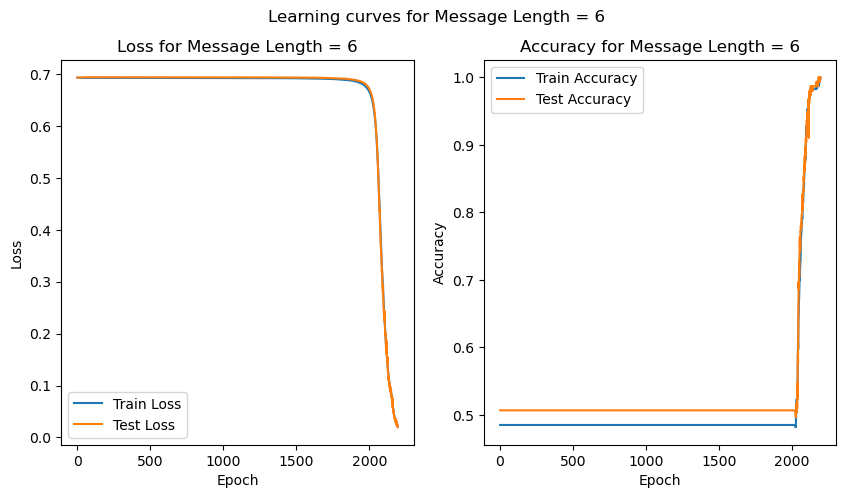

  3%|▎         | 1/30 [05:22<2:35:47, 322.32s/it]

Repeat: 1 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.52
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.63
Repeat: 1 - Epoch: 1700 - Test Accuracy: 0.9133333333333333


  7%|▋         | 2/30 [09:44<2:14:00, 287.16s/it]

Repeat: 2 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 2 - Epoch: 1700 - Test Accuracy: 0.506666

 10%|█         | 3/30 [17:45<2:48:59, 375.55s/it]

Repeat: 3 - Epoch: 100 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 200 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 300 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 400 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 500 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 600 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 700 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 800 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 900 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 1000 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 1100 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 1200 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 1300 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 1400 - Test Accuracy: 0.45
Repeat: 3 - Epoch: 1500 - Test Accuracy: 0.47
Repeat: 3 - Epoch: 1600 - Test Accuracy: 0.63
Repeat: 3 - Epoch: 1700 - Test Accuracy: 1.0


 13%|█▎        | 4/30 [22:45<2:29:43, 345.52s/it]

Repeat: 4 - Epoch: 100 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 200 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 300 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 400 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 500 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 600 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 700 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 800 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 900 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 1000 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 1100 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 1200 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 1300 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 1400 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 1500 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 1600 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 1700 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 1800 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 1900 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 2000 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 2100 - Test Accuracy: 0.53
Repeat: 4 - Epoch: 2200 - Test Accuracy: 0.

 17%|█▋        | 5/30 [28:53<2:27:21, 353.65s/it]

Repeat: 5 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 1100 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 1200 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 1300 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 1400 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 1500 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 1600 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 1700 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 1800 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 1900 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 2000 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 2100 - Test Accuracy: 0.52
Repeat: 5 - Epoch: 2200 - Test Accuracy: 0.

 20%|██        | 6/30 [35:41<2:28:54, 372.27s/it]

Repeat: 6 - Epoch: 100 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 200 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 300 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 400 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 500 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 600 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 700 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 800 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 900 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 1000 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 1100 - Test Accuracy: 0.5433333333333333
Repeat: 6 - Epoch: 1200 - Test Accuracy: 0.5333333333333333
Repeat: 6 - Epoch: 1300 - Test Accuracy: 0.6933333333333334
Repeat: 6 - Epoch: 1400 - Test Accuracy: 0.8833333333333333
Repeat: 6 - Epoch: 1500 - Test Accuracy: 0.8966666666666666
Repeat: 6 - Epoch: 1600 - Test Accuracy: 1.0


 23%|██▎       | 7/30 [40:14<2:10:15, 339.82s/it]

Repeat: 7 - Epoch: 100 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 200 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 300 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 400 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 500 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 600 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 700 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 800 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 900 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 1000 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 1100 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 1200 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 1300 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 1400 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 1500 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 1600 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 1700 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 1800 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 1900 - Test Accuracy: 0.48
Repeat: 7 - Epoch: 2000 - Test Accuracy: 0.6533333333333333
Repeat: 7 - Epoch: 2100 - Test Accuracy: 1.0


 27%|██▋       | 8/30 [46:30<2:08:47, 351.23s/it]

Repeat: 8 - Epoch: 100 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 200 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 300 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 400 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 900 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 1000 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 1100 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 1200 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 1300 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 1400 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 1500 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 1600 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 1700 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 1800 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 1900 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 2000 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 2100 - Test Accuracy: 0.51
Repeat: 8 - Epoch: 2200 - Test Accuracy: 0.

 30%|███       | 9/30 [55:08<2:21:12, 403.43s/it]

Repeat: 9 - Epoch: 100 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 200 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 300 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 400 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 500 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 600 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 700 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 800 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 900 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1000 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1100 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1200 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1300 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1400 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1500 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1600 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1700 - Test Accuracy: 0.466666

 33%|███▎      | 10/30 [1:00:25<2:05:33, 376.67s/it]

Repeat: 10 - Epoch: 100 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 200 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 300 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 400 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 900 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 1000 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 1100 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 1200 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 1300 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 1400 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 1500 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 1600 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 1700 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 1800 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 1900 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 2000 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 2100 - Test Accuracy: 0.51
Repeat: 10 - Epoch: 22

 37%|███▋      | 11/30 [1:08:33<2:10:05, 410.84s/it]

Repeat: 11 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 11 - Epoch: 1700 - Test A

 40%|████      | 12/30 [1:14:29<1:58:14, 394.15s/it]

Repeat: 12 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 1000 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 1100 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 1200 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 1300 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 1400 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 1500 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoch: 1600 - Test Accuracy: 0.48333333333333334
Repeat: 12 - Epoc

 43%|████▎     | 13/30 [1:20:27<1:48:33, 383.12s/it]

Repeat: 13 - Epoch: 100 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 200 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 900 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 1000 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 1100 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 1200 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 1300 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 1400 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 1500 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 1600 - Test Accuracy: 0.5366666666666666
Repeat: 13 - Epoch: 1700 - Test A

 47%|████▋     | 14/30 [1:24:57<1:33:06, 349.13s/it]

Repeat: 14 - Epoch: 100 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 200 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 300 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 400 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 500 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 600 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 700 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 800 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 900 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 1000 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 1100 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 1200 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 1300 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 1400 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 1500 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 1600 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 1700 - Test Accuracy: 0.44
Repeat: 14 - Epoch: 1800 - Test Accuracy: 0.7733333333333333
Repeat: 14 - Epoch: 1900 - Test Accuracy: 1.0


 50%|█████     | 15/30 [1:29:50<1:23:00, 332.04s/it]

Repeat: 15 - Epoch: 100 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 200 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 300 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 400 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 500 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 600 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 700 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 800 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 900 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 1000 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 1100 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 1200 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 1300 - Test Accuracy: 0.53
Repeat: 15 - Epoch: 1400 - Test Accuracy: 0.54
Repeat: 15 - Epoch: 1500 - Test Accuracy: 0.9433333333333334


 53%|█████▎    | 16/30 [1:33:37<1:10:04, 300.35s/it]

Repeat: 16 - Epoch: 100 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 200 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 300 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 400 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 500 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 600 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 700 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 800 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 900 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 1000 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 1100 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 1200 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 1300 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 1400 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 1500 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 1600 - Test Accuracy: 0.5333333333333333
Repeat: 16 - Epoch: 1700 - Test A

 57%|█████▋    | 17/30 [1:39:49<1:09:45, 322.00s/it]

Repeat: 17 - Epoch: 100 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 200 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 300 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 400 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 500 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 600 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 700 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 800 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 900 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 1000 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 1100 - Test Accuracy: 0.44
Repeat: 17 - Epoch: 1200 - Test Accuracy: 0.4533333333333333
Repeat: 17 - Epoch: 1300 - Test Accuracy: 0.8433333333333334
Repeat: 17 - Epoch: 1400 - Test Accuracy: 1.0


 60%|██████    | 18/30 [1:44:22<1:01:28, 307.34s/it]

Repeat: 18 - Epoch: 100 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 200 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 300 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 400 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 900 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1000 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1100 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1200 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1300 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1400 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1500 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1600 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1700 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1800 - Test Accuracy: 0.5933333333333334
Repeat: 18 - Epoch: 1900 - Test Accuracy: 0.9333333333333333


 63%|██████▎   | 19/30 [1:50:15<58:49, 320.89s/it]  

Repeat: 19 - Epoch: 100 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 600 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 700 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 800 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 900 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1000 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1100 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1200 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1300 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1400 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1500 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1600 - Test Accuracy: 0.4633333333333333
Repeat: 19 - Epoch: 1700 - Test A

 67%|██████▋   | 20/30 [1:55:40<53:42, 322.23s/it]

Repeat: 20 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 20 - Epoch: 1200 - Test Accuracy: 0.5466666666666666
Repeat: 20 - Epoch: 1300 - Test Accuracy: 0.9933333333333333


 70%|███████   | 21/30 [1:59:10<43:18, 288.67s/it]

Repeat: 21 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 1000 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 1100 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 1200 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 1300 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 1400 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 1500 - Test Accuracy: 0.48333333333333334
Repeat: 21 - Epoch: 1600 - Test Accuracy: 0.66
Repeat: 21 - Epoch: 1700 - Test 

 73%|███████▎  | 22/30 [2:04:15<39:07, 293.48s/it]

Repeat: 22 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 1100 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 1200 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 1300 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 1400 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 1500 - Test Accuracy: 0.52
Repeat: 22 - Epoch: 1600 - Test Accuracy: 0.64
Repeat: 22 - Epoch: 1700 - Test Accuracy: 0.9633333333333334


 77%|███████▋  | 23/30 [2:10:02<36:06, 309.51s/it]

Repeat: 23 - Epoch: 100 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 200 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 300 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 400 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 500 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 600 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 700 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 800 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 900 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 1000 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 1100 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 1200 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 1300 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 1400 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 1500 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 1600 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 1700 - Test Accuracy: 0.49
Repeat: 23 - Epoch: 1800 - Test Accuracy: 0.9733333333333334


 80%|████████  | 24/30 [2:15:03<30:42, 307.03s/it]

Repeat: 24 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1500 - Test Accuracy: 0.6366666666666667
Repeat: 24 - Epoch: 1600 - Test Accuracy: 0.7666666666666667
Repeat: 24 - Epoch: 1700 - Test A

 83%|████████▎ | 25/30 [2:20:00<25:19, 303.95s/it]

Repeat: 25 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1500 - Test Accuracy: 0.5033333333333333
Repeat: 25 - Epoch: 1600 - Test Accuracy: 0.5233333333333333
Repeat: 25 - Epoch: 1700 - Test A

 87%|████████▋ | 26/30 [2:25:31<20:48, 312.08s/it]

Repeat: 26 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 1100 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 1200 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 1300 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 1400 - Test Accuracy: 0.52
Repeat: 26 - Epoch: 1500 - Test Accuracy: 0.8733333333333333


 90%|█████████ | 27/30 [2:30:12<15:07, 302.63s/it]

Repeat: 27 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 1000 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 1100 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 1200 - Test Accuracy: 0.48333333333333334
Repeat: 27 - Epoch: 1300 - Test Accuracy: 0.9633333333333334


 93%|█████████▎| 28/30 [2:34:12<09:28, 284.12s/it]

Repeat: 28 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 1000 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 1100 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 1200 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 1300 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 1400 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 1500 - Test Accuracy: 0.48333333333333334
Repeat: 28 - Epoch: 1600 - Test Accuracy: 0.68
Repeat: 28 - Epoch: 1700 - Test 

 97%|█████████▋| 29/30 [2:38:40<04:39, 279.10s/it]

Repeat: 29 - Epoch: 100 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 200 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 300 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 400 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 500 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 600 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 700 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 800 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 900 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1000 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1100 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1200 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1300 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1400 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1500 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1600 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1700 - Test A

100%|██████████| 30/30 [2:45:43<00:00, 331.44s/it]


len_message = 5


  0%|          | 0/30 [00:00<?, ?it/s]

Repeat: 0 - Epoch: 100 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 1000 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 1100 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 1200 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 1300 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 1400 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 1500 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 1600 - Test Accuracy: 0.5266666666666666
Repeat: 0 - Epoch: 1700 - Test Accuracy: 0.526666

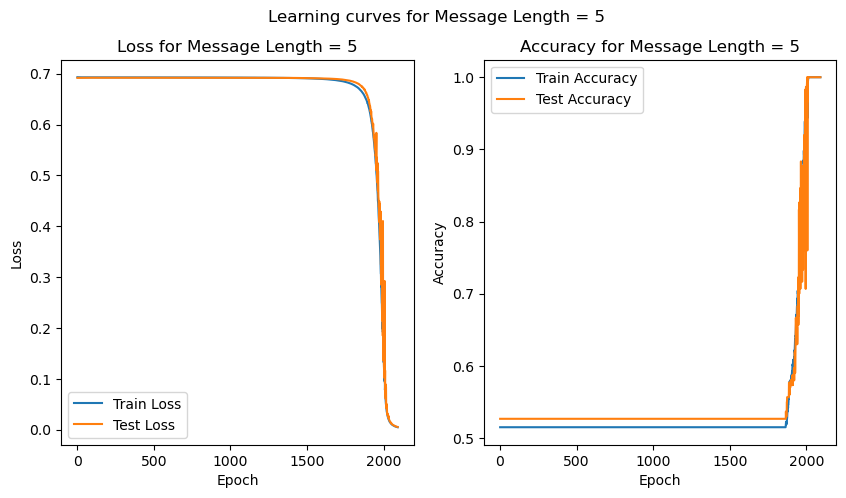

  3%|▎         | 1/30 [05:59<2:53:37, 359.22s/it]

Repeat: 1 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1700 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1800 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1900 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 2000 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 2100 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 2200 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 

  7%|▋         | 2/30 [12:24<2:54:52, 374.73s/it]

Repeat: 2 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 1400 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 1500 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 1600 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 1700 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 1800 - Test Accuracy: 0.7233333333333334
Repeat: 2 - Epoch: 1900 - Test Accuracy: 0.98


 10%|█         | 3/30 [17:42<2:36:55, 348.72s/it]

Repeat: 3 - Epoch: 100 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 200 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 300 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 400 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 500 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 600 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 700 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 800 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 900 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 1000 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 1100 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 1200 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 1300 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 1400 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 1500 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 1600 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 1700 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 1800 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 1900 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 2000 - Test Accuracy: 0.49
Repeat: 3 - Epoch: 2100 - Test Accuracy: 0.5033333333333333
Repeat: 3 - Epoch: 2200 - Tes

 13%|█▎        | 4/30 [23:52<2:34:44, 357.08s/it]

Repeat: 4 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 1000 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 1100 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 1200 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 1300 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 1400 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 1500 - Test Accuracy: 0.48333333333333334
Repeat: 4 - Epoch: 1600 - Test Accuracy: 0.6466666666666666
Repeat: 4 - Epoch: 1700 - Test Acc

 17%|█▋        | 5/30 [28:31<2:16:59, 328.79s/it]

Repeat: 5 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 1500 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 1600 - Test Accuracy: 0.49333333333333335
Repeat: 5 - Epoch: 1700 - Test Ac

 20%|██        | 6/30 [34:29<2:15:31, 338.81s/it]

Repeat: 6 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 1400 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 1500 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 1600 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 1700 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 1800 - Test Accuracy: 0.5
Repeat: 6 - Epoch: 1900 - Test Accuracy: 0.8133333333333334
Repeat: 6 - Epoch: 2000 - Test Accuracy: 1.0


 23%|██▎       | 7/30 [39:46<2:07:12, 331.84s/it]

Repeat: 7 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1500 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1600 - Test Accuracy: 0.5033333333333333
Repeat: 7 - Epoch: 1700 - Test Accuracy: 0.503333

 27%|██▋       | 8/30 [45:38<2:03:58, 338.12s/it]

Repeat: 8 - Epoch: 100 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 200 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 300 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 400 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 500 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 600 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 700 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 800 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 900 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1000 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1100 - Test Accuracy: 0.5333333333333333
Repeat: 8 - Epoch: 1200 - Test Accuracy: 0.8733333333333333
Repeat: 8 - Epoch: 1300 - Test Accuracy: 1.0


 30%|███       | 9/30 [49:06<1:44:06, 297.47s/it]

Repeat: 9 - Epoch: 100 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 200 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 300 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 400 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 500 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 600 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 700 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 800 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 900 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1000 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1100 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1200 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1300 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1400 - Test Accuracy: 0.4666666666666667
Repeat: 9 - Epoch: 1500 - Test Accuracy: 0.8766666666666667
Repeat: 9 - Epoch: 1600 - Test Accuracy: 1.0


 33%|███▎      | 10/30 [53:28<1:35:33, 286.66s/it]

Repeat: 10 - Epoch: 100 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 200 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 300 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 400 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 500 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 600 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 700 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 800 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 900 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 1000 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 1100 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 1200 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 1300 - Test Accuracy: 0.45666666666666667
Repeat: 10 - Epoch: 1400 - Test Accuracy: 0.85
Repeat: 10 - Epoch: 1500 - Test Accuracy: 1.0


 37%|███▋      | 11/30 [57:50<1:28:22, 279.07s/it]

Repeat: 11 - Epoch: 100 - Test Accuracy: 0.54
Repeat: 11 - Epoch: 200 - Test Accuracy: 0.54
Repeat: 11 - Epoch: 300 - Test Accuracy: 0.54
Repeat: 11 - Epoch: 400 - Test Accuracy: 0.54
Repeat: 11 - Epoch: 500 - Test Accuracy: 0.54
Repeat: 11 - Epoch: 600 - Test Accuracy: 0.54
Repeat: 11 - Epoch: 700 - Test Accuracy: 0.54
Repeat: 11 - Epoch: 800 - Test Accuracy: 0.54
Repeat: 11 - Epoch: 900 - Test Accuracy: 0.54
Repeat: 11 - Epoch: 1000 - Test Accuracy: 0.5966666666666667
Repeat: 11 - Epoch: 1100 - Test Accuracy: 1.0


 40%|████      | 12/30 [1:01:24<1:17:46, 259.25s/it]

Repeat: 12 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 1300 - Test Accuracy: 0.5766666666666667
Repeat: 12 - Epoch: 1400 - Test Accuracy: 1.0


 43%|████▎     | 13/30 [1:05:58<1:14:43, 263.72s/it]

Repeat: 13 - Epoch: 100 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 200 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 900 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 1000 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 1100 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 1200 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 1300 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 1400 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 1500 - Test Accuracy: 0.47
Repeat: 13 - Epoch: 1600 - Test Accuracy: 0.56
Repeat: 13 - Epoch: 1700 - Test Accuracy: 1.0


 47%|████▋     | 14/30 [1:10:34<1:11:18, 267.42s/it]

Repeat: 14 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 1500 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 1600 - Test Accuracy: 0.5166666666666667
Repeat: 14 - Epoch: 1700 - Test A

 50%|█████     | 15/30 [1:17:49<1:19:25, 317.73s/it]

Repeat: 15 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 15 - Epoch: 1500 - Test Accuracy: 0.7033333333333334
Repeat: 15 - Epoch: 1600 - Test Accuracy: 1.0


 53%|█████▎    | 16/30 [1:22:25<1:11:15, 305.42s/it]

Repeat: 16 - Epoch: 100 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 200 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 300 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 400 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 500 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 600 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 700 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 800 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 900 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 1000 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 1100 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 1200 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 1300 - Test Accuracy: 0.4866666666666667
Repeat: 16 - Epoch: 1400 - Test Accuracy: 0.6366666666666667
Repeat: 16 - Epoch: 1500 - Test Accuracy: 0.8933333333333333
Repeat: 16 - Epoch: 1600 - Test Accuracy: 1.0


 57%|█████▋    | 17/30 [1:26:54<1:03:48, 294.47s/it]

Repeat: 17 - Epoch: 100 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 200 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 300 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 400 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 500 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 600 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 700 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 800 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 900 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 1000 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 1100 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 1200 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 1300 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 1400 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 1500 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 1600 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 1700 - Test A

 60%|██████    | 18/30 [1:31:36<58:06, 290.55s/it]  

Repeat: 18 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 1700 - Test A

 63%|██████▎   | 19/30 [2:02:17<2:18:40, 756.37s/it]

Repeat: 19 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 1400 - Test Accuracy: 0.4866666666666667
Repeat: 19 - Epoch: 1500 - Test Accuracy: 1.0


 67%|██████▋   | 20/30 [2:06:16<1:40:10, 601.03s/it]

Repeat: 20 - Epoch: 100 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 200 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 300 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 400 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 500 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 600 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 700 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 800 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 900 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 1000 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 1100 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 1200 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 1300 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 1400 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 1500 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 1600 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 1700 - Test Accuracy: 0.48
Repeat: 20 - Epoch: 1800 - Test Accuracy: 0.41333333333333333
Repeat: 20 - Epoch: 1900 - Test Accuracy: 0.8766666666666667
Repeat: 20 - Epoch: 2000 - Test Accuracy: 1.0


 70%|███████   | 21/30 [2:11:09<1:16:16, 508.55s/it]

Repeat: 21 - Epoch: 100 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 200 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 300 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 400 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 500 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 600 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 700 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 800 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 900 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 1000 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 1100 - Test Accuracy: 0.44666666666666666
Repeat: 21 - Epoch: 1200 - Test Accuracy: 0.5233333333333333
Repeat: 21 - Epoch: 1300 - Test Accuracy: 0.8733333333333333
Repeat: 21 - Epoch: 1400 - Test Accuracy: 0.9566666666666667


 73%|███████▎  | 22/30 [2:14:57<56:34, 424.30s/it]  

Repeat: 22 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 1200 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 1300 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 1400 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 1500 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoch: 1600 - Test Accuracy: 0.49666666666666665
Repeat: 22 - Epoc

 77%|███████▋  | 23/30 [2:20:14<45:44, 392.13s/it]

Repeat: 23 - Epoch: 100 - Test Accuracy: 0.46
Repeat: 23 - Epoch: 200 - Test Accuracy: 0.46
Repeat: 23 - Epoch: 300 - Test Accuracy: 0.46
Repeat: 23 - Epoch: 400 - Test Accuracy: 0.46
Repeat: 23 - Epoch: 500 - Test Accuracy: 0.46
Repeat: 23 - Epoch: 600 - Test Accuracy: 0.46
Repeat: 23 - Epoch: 700 - Test Accuracy: 0.46
Repeat: 23 - Epoch: 800 - Test Accuracy: 0.46
Repeat: 23 - Epoch: 900 - Test Accuracy: 0.46
Repeat: 23 - Epoch: 1000 - Test Accuracy: 0.67
Repeat: 23 - Epoch: 1100 - Test Accuracy: 1.0


 80%|████████  | 24/30 [2:23:04<32:32, 325.34s/it]

Repeat: 24 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.5
Repeat: 24 - Epoch: 1500 - Test Accuracy: 0.57
Repeat: 24 - Epoch: 1600 - Test Accuracy: 1.0


 83%|████████▎ | 25/30 [2:27:05<25:00, 300.05s/it]

Repeat: 25 - Epoch: 100 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 200 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 300 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 400 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 500 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 600 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 700 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 800 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 900 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 1000 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 1100 - Test Accuracy: 0.44666666666666666
Repeat: 25 - Epoch: 1200 - Test Accuracy: 0.5633333333333334
Repeat: 25 - Epoch: 1300 - Test Accuracy: 1.0


 87%|████████▋ | 26/30 [2:30:23<17:58, 269.59s/it]

Repeat: 26 - Epoch: 100 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 200 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 300 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 400 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 500 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 600 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 700 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 800 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 900 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 1000 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 1100 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 1200 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 1300 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 1400 - Test Accuracy: 0.5333333333333333
Repeat: 26 - Epoch: 1500 - Test Accuracy: 0.8433333333333334
Repeat: 26 - Epoch: 1600 - Test Accuracy: 1.0


 90%|█████████ | 27/30 [2:34:22<13:01, 260.47s/it]

Repeat: 27 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 1100 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 1200 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 1300 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 1400 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 1500 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 1600 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 1700 - Test A

 93%|█████████▎| 28/30 [2:39:37<09:13, 276.72s/it]

Repeat: 28 - Epoch: 100 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 200 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 300 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 400 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 500 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 600 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 700 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 800 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 900 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 1000 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 1100 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 1200 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 1300 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 1400 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 28 - Epoch: 1600 - Test Accuracy: 0.98


 97%|█████████▋| 29/30 [2:43:43<04:27, 267.62s/it]

Repeat: 29 - Epoch: 100 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 200 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 300 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 400 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 500 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 600 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 700 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 800 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 900 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1000 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1100 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1200 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1300 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1400 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 1500 - Test Accuracy: 0.6566666666666666
Repeat: 29 - Epoch: 1600 - Test Accuracy: 0.88
Repeat: 29 - Epoch: 1700 - Test Accuracy: 0.993

100%|██████████| 30/30 [2:47:55<00:00, 335.85s/it]


len_message = 4


  0%|          | 0/30 [00:00<?, ?it/s]

Repeat: 0 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 0 - Epoch: 1200 - Test Accuracy: 1.0


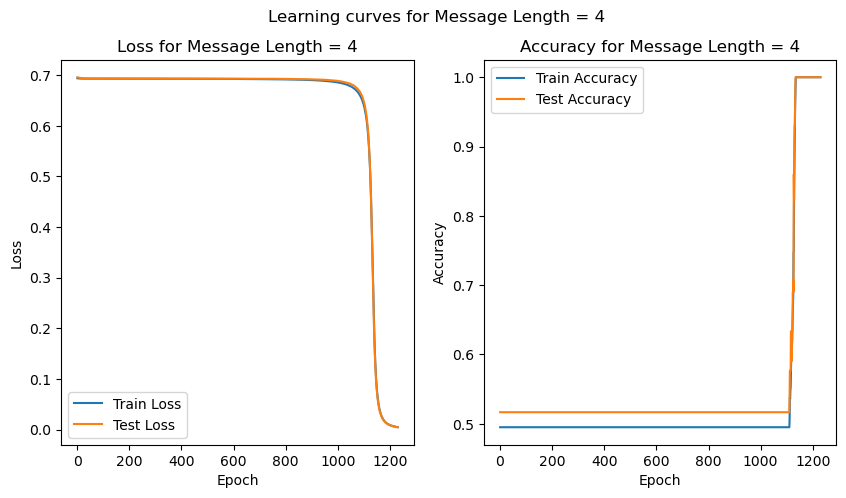

  3%|▎         | 1/30 [02:57<1:25:50, 177.62s/it]

Repeat: 1 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.62
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.8933333333333333
Repeat: 1 - Epoch: 1100 - Test Accuracy: 1.0


  7%|▋         | 2/30 [05:39<1:18:28, 168.17s/it]

Repeat: 2 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 1200 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 1300 - Test Accuracy: 0.5733333333333334
Repeat: 2 - Epoch: 1400 - Test Accuracy: 1.0


 10%|█         | 3/30 [09:08<1:24:11, 187.11s/it]

Repeat: 3 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 3 - Epoch: 1400 - Test Accuracy: 0.61
Repeat: 3 - Epoch: 1500 - Test Accuracy: 1.0


 13%|█▎        | 4/30 [12:55<1:27:47, 202.61s/it]

Repeat: 4 - Epoch: 100 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 200 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 300 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 400 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 500 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 600 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 700 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 800 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 900 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1000 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1100 - Test Accuracy: 0.55
Repeat: 4 - Epoch: 1200 - Test Accuracy: 0.61
Repeat: 4 - Epoch: 1300 - Test Accuracy: 1.0


 17%|█▋        | 5/30 [16:14<1:23:57, 201.50s/it]

Repeat: 5 - Epoch: 100 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 200 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 300 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 400 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 500 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 600 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 700 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 800 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 900 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 1000 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 1100 - Test Accuracy: 0.5433333333333333
Repeat: 5 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 5 - Epoch: 1300 - Test Accuracy: 0.9466666666666667


 20%|██        | 6/30 [19:37<1:20:49, 202.06s/it]

Repeat: 6 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 6 - Epoch: 900 - Test Accuracy: 0.3933333333333333
Repeat: 6 - Epoch: 1000 - Test Accuracy: 0.9166666666666666


 23%|██▎       | 7/30 [22:17<1:12:04, 188.03s/it]

Repeat: 7 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 1000 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 1100 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 1200 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 1300 - Test Accuracy: 0.48333333333333334
Repeat: 7 - Epoch: 1400 - Test Accuracy: 1.0


 27%|██▋       | 8/30 [25:53<1:12:16, 197.12s/it]

Repeat: 8 - Epoch: 100 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 200 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 300 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 400 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 500 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 600 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 700 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 800 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 900 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1000 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1100 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1200 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1300 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1400 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1500 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1600 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1700 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1800 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 1900 - Test Accuracy: 0.49
Repeat: 8 - Epoch: 2000 - Test Accuracy: 0.9333333333333333


 30%|███       | 9/30 [31:02<1:21:14, 232.11s/it]

Repeat: 9 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 9 - Epoch: 1400 - Test Accuracy: 0.8233333333333334
Repeat: 9 - Epoch: 1500 - Test Accuracy: 1.0


 33%|███▎      | 10/30 [34:52<1:17:07, 231.36s/it]

Repeat: 10 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 1100 - Test Accuracy: 0.4766666666666667
Repeat: 10 - Epoch: 1200 - Test Accuracy: 0.9233333333333333


 37%|███▋      | 11/30 [37:58<1:08:50, 217.42s/it]

Repeat: 11 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 11 - Epoch: 1200 - Test Accuracy: 0.8333333333333334
Repeat: 11 - Epoch: 1300 - Test Accuracy: 1.0


 40%|████      | 12/30 [41:07<1:02:41, 208.95s/it]

Repeat: 12 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 1400 - Test Accuracy: 0.5
Repeat: 12 - Epoch: 1500 - Test Accuracy: 0.5533333333333333
Repeat: 12 - Epoch: 1600 - Test Accuracy: 0.9733333333333334


 43%|████▎     | 13/30 [45:11<1:02:10, 219.42s/it]

Repeat: 13 - Epoch: 100 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 200 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 900 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 1000 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 1100 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 1200 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 1300 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 1400 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 1500 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 1600 - Test Accuracy: 0.5133333333333333
Repeat: 13 - Epoch: 1700 - Test A

 47%|████▋     | 14/30 [53:06<1:19:05, 296.60s/it]

Repeat: 14 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 900 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 1000 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 1100 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 1200 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 1300 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 1400 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 1500 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 1600 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 1700 - Test A

 50%|█████     | 15/30 [57:48<1:13:03, 292.23s/it]

Repeat: 15 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 1300 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 1400 - Test Accuracy: 0.5
Repeat: 15 - Epoch: 1500 - Test Accuracy: 0.5966666666666667
Repeat: 15 - Epoch: 1600 - Test Accuracy: 1.0


 53%|█████▎    | 16/30 [1:01:48<1:04:31, 276.53s/it]

Repeat: 16 - Epoch: 100 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 200 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 300 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 400 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 500 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 600 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 700 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 800 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 900 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 1000 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 1100 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 1200 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 1300 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 1400 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 1500 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 1600 - Test Accuracy: 0.4533333333333333
Repeat: 16 - Epoch: 1700 - Test A

 57%|█████▋    | 17/30 [1:06:18<59:28, 274.51s/it]  

Repeat: 17 - Epoch: 100 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 200 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 300 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 400 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 500 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 600 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 700 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 800 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 900 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 1000 - Test Accuracy: 0.4633333333333333
Repeat: 17 - Epoch: 1100 - Test Accuracy: 0.8566666666666667
Repeat: 17 - Epoch: 1200 - Test Accuracy: 1.0


 60%|██████    | 18/30 [1:09:11<48:48, 244.02s/it]

Repeat: 18 - Epoch: 100 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 200 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 300 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 400 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 900 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1000 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1100 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1200 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1300 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1400 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1500 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 1600 - Test Accuracy: 0.64
Repeat: 18 - Epoch: 1700 - Test Accuracy: 1.0


 63%|██████▎   | 19/30 [1:13:21<45:05, 245.96s/it]

Repeat: 19 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 1100 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 1200 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 1300 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 1400 - Test Accuracy: 0.4766666666666667
Repeat: 19 - Epoch: 1500 - Test Accuracy: 0.7133333333333334
Repeat: 19 - Epoch: 1600 - Test Accuracy: 0.81
Repeat: 19 - Epoch: 1700 - Test Accuracy: 0.916

 67%|██████▋   | 20/30 [1:17:39<41:34, 249.42s/it]

Repeat: 20 - Epoch: 100 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 200 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 300 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 400 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 500 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 600 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 700 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 800 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 900 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 1000 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 1100 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 1200 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 1300 - Test Accuracy: 0.49
Repeat: 20 - Epoch: 1400 - Test Accuracy: 1.0


 70%|███████   | 21/30 [1:21:06<35:30, 236.68s/it]

Repeat: 21 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 21 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 21 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 21 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 21 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 21 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 21 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 21 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 21 - Epoch: 900 - Test Accuracy: 0.77
Repeat: 21 - Epoch: 1000 - Test Accuracy: 1.0


 73%|███████▎  | 22/30 [1:23:32<27:57, 209.69s/it]

Repeat: 22 - Epoch: 100 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 200 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 300 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 400 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 500 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 600 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 700 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 800 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 900 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 1000 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 1100 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 1200 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 1300 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 1400 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 1500 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 1600 - Test Accuracy: 0.5233333333333333
Repeat: 22 - Epoch: 1700 - Test A

 77%|███████▋  | 23/30 [1:28:47<28:07, 241.12s/it]

Repeat: 23 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 23 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 23 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 23 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 23 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 23 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 23 - Epoch: 700 - Test Accuracy: 0.6466666666666666
Repeat: 23 - Epoch: 800 - Test Accuracy: 0.87


 80%|████████  | 24/30 [1:30:57<20:46, 207.76s/it]

Repeat: 24 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.6566666666666666
Repeat: 24 - Epoch: 1500 - Test Accuracy: 0.98


 83%|████████▎ | 25/30 [1:34:43<17:46, 213.32s/it]

Repeat: 25 - Epoch: 100 - Test Accuracy: 0.55
Repeat: 25 - Epoch: 200 - Test Accuracy: 0.55
Repeat: 25 - Epoch: 300 - Test Accuracy: 0.55
Repeat: 25 - Epoch: 400 - Test Accuracy: 0.55
Repeat: 25 - Epoch: 500 - Test Accuracy: 0.55
Repeat: 25 - Epoch: 600 - Test Accuracy: 0.55
Repeat: 25 - Epoch: 700 - Test Accuracy: 0.55
Repeat: 25 - Epoch: 800 - Test Accuracy: 0.55
Repeat: 25 - Epoch: 900 - Test Accuracy: 0.55
Repeat: 25 - Epoch: 1000 - Test Accuracy: 0.55
Repeat: 25 - Epoch: 1100 - Test Accuracy: 0.61
Repeat: 25 - Epoch: 1200 - Test Accuracy: 1.0


 87%|████████▋ | 26/30 [1:37:44<13:34, 203.72s/it]

Repeat: 26 - Epoch: 100 - Test Accuracy: 0.54
Repeat: 26 - Epoch: 200 - Test Accuracy: 0.54
Repeat: 26 - Epoch: 300 - Test Accuracy: 0.54
Repeat: 26 - Epoch: 400 - Test Accuracy: 0.54
Repeat: 26 - Epoch: 500 - Test Accuracy: 0.54
Repeat: 26 - Epoch: 600 - Test Accuracy: 0.54
Repeat: 26 - Epoch: 700 - Test Accuracy: 0.54
Repeat: 26 - Epoch: 800 - Test Accuracy: 0.7433333333333333
Repeat: 26 - Epoch: 900 - Test Accuracy: 0.9533333333333334


 90%|█████████ | 27/30 [1:40:09<09:17, 185.86s/it]

Repeat: 27 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 1200 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 1300 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 1400 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 1500 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoch: 1600 - Test Accuracy: 0.49666666666666665
Repeat: 27 - Epoc

 93%|█████████▎| 28/30 [1:45:26<07:30, 225.47s/it]

Repeat: 28 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 28 - Epoch: 1500 - Test Accuracy: 1.0


 97%|█████████▋| 29/30 [1:49:17<03:46, 227.00s/it]

Repeat: 29 - Epoch: 100 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 200 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 300 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 400 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 500 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 600 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 700 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 800 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 900 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 1000 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 1100 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 1200 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 1300 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 1400 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 1500 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 1600 - Test Accuracy: 0.4533333333333333
Repeat: 29 - Epoch: 1700 - Test A

100%|██████████| 30/30 [1:54:38<00:00, 229.27s/it]


len_message = 3


  0%|          | 0/30 [00:00<?, ?it/s]

Repeat: 0 - Epoch: 100 - Test Accuracy: 0.4633333333333333
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.4633333333333333
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.4633333333333333
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.4633333333333333
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.4633333333333333
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.4633333333333333
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.4633333333333333
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.4633333333333333
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.92
Repeat: 0 - Epoch: 1000 - Test Accuracy: 1.0


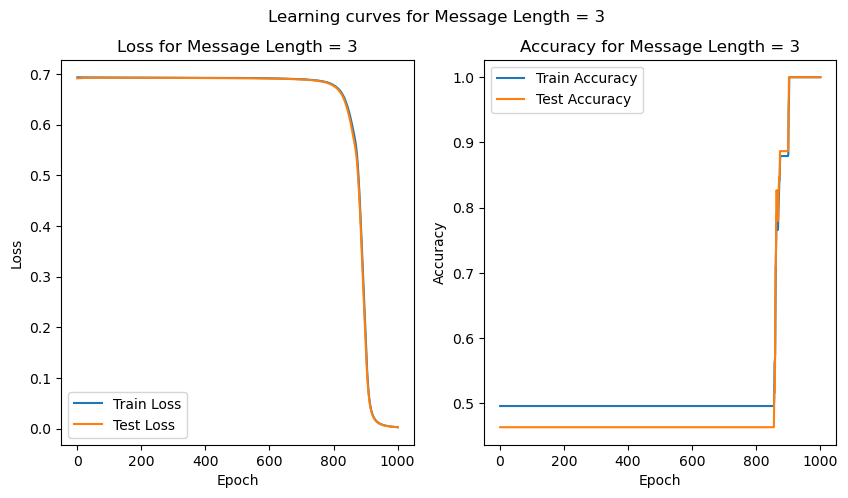

  3%|▎         | 1/30 [02:24<1:09:57, 144.75s/it]

Repeat: 1 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 1 - Epoch: 1000 - Test Accuracy: 1.0


  7%|▋         | 2/30 [05:05<1:11:53, 154.04s/it]

Repeat: 2 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 2 - Epoch: 700 - Test Accuracy: 1.0


 10%|█         | 3/30 [07:00<1:01:25, 136.49s/it]

Repeat: 3 - Epoch: 100 - Test Accuracy: 0.5133333333333333
Repeat: 3 - Epoch: 200 - Test Accuracy: 0.5133333333333333
Repeat: 3 - Epoch: 300 - Test Accuracy: 0.5133333333333333
Repeat: 3 - Epoch: 400 - Test Accuracy: 0.5133333333333333
Repeat: 3 - Epoch: 500 - Test Accuracy: 0.5133333333333333
Repeat: 3 - Epoch: 600 - Test Accuracy: 0.5133333333333333
Repeat: 3 - Epoch: 700 - Test Accuracy: 0.5133333333333333
Repeat: 3 - Epoch: 800 - Test Accuracy: 0.77
Repeat: 3 - Epoch: 900 - Test Accuracy: 1.0


 13%|█▎        | 4/30 [09:15<58:47, 135.69s/it]  

Repeat: 4 - Epoch: 100 - Test Accuracy: 0.4866666666666667
Repeat: 4 - Epoch: 200 - Test Accuracy: 0.4866666666666667
Repeat: 4 - Epoch: 300 - Test Accuracy: 0.4866666666666667
Repeat: 4 - Epoch: 400 - Test Accuracy: 0.4866666666666667
Repeat: 4 - Epoch: 500 - Test Accuracy: 0.4866666666666667
Repeat: 4 - Epoch: 600 - Test Accuracy: 0.4866666666666667
Repeat: 4 - Epoch: 700 - Test Accuracy: 0.4866666666666667
Repeat: 4 - Epoch: 800 - Test Accuracy: 0.4866666666666667
Repeat: 4 - Epoch: 900 - Test Accuracy: 0.4866666666666667
Repeat: 4 - Epoch: 1000 - Test Accuracy: 0.8033333333333333
Repeat: 4 - Epoch: 1100 - Test Accuracy: 1.0


 17%|█▋        | 5/30 [11:59<1:00:47, 145.91s/it]

Repeat: 5 - Epoch: 100 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 200 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 300 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 400 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 500 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 600 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 700 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 800 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 900 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 1000 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 1100 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 1200 - Test Accuracy: 0.55
Repeat: 5 - Epoch: 1300 - Test Accuracy: 0.77
Repeat: 5 - Epoch: 1400 - Test Accuracy: 1.0


 20%|██        | 6/30 [15:25<1:06:29, 166.21s/it]

Repeat: 6 - Epoch: 100 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 200 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 300 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 400 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 500 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 600 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 700 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 800 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 900 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 1000 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 1100 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 1200 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 1300 - Test Accuracy: 0.4866666666666667
Repeat: 6 - Epoch: 1400 - Test Accuracy: 1.0


 23%|██▎       | 7/30 [19:00<1:09:56, 182.44s/it]

Repeat: 7 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 7 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 7 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 7 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 7 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 7 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 7 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 7 - Epoch: 800 - Test Accuracy: 1.0


 27%|██▋       | 8/30 [21:09<1:00:35, 165.25s/it]

Repeat: 8 - Epoch: 100 - Test Accuracy: 0.39666666666666667
Repeat: 8 - Epoch: 200 - Test Accuracy: 0.39666666666666667
Repeat: 8 - Epoch: 300 - Test Accuracy: 0.39666666666666667
Repeat: 8 - Epoch: 400 - Test Accuracy: 0.39666666666666667
Repeat: 8 - Epoch: 500 - Test Accuracy: 0.39666666666666667
Repeat: 8 - Epoch: 600 - Test Accuracy: 0.39666666666666667
Repeat: 8 - Epoch: 700 - Test Accuracy: 0.39666666666666667
Repeat: 8 - Epoch: 800 - Test Accuracy: 0.39666666666666667
Repeat: 8 - Epoch: 900 - Test Accuracy: 0.39666666666666667
Repeat: 8 - Epoch: 1000 - Test Accuracy: 0.39666666666666667
Repeat: 8 - Epoch: 1100 - Test Accuracy: 0.5466666666666666
Repeat: 8 - Epoch: 1200 - Test Accuracy: 1.0


 30%|███       | 9/30 [24:08<59:18, 169.46s/it]  

Repeat: 9 - Epoch: 100 - Test Accuracy: 0.5233333333333333
Repeat: 9 - Epoch: 200 - Test Accuracy: 0.5233333333333333
Repeat: 9 - Epoch: 300 - Test Accuracy: 0.5233333333333333
Repeat: 9 - Epoch: 400 - Test Accuracy: 0.5233333333333333
Repeat: 9 - Epoch: 500 - Test Accuracy: 0.5233333333333333
Repeat: 9 - Epoch: 600 - Test Accuracy: 0.5233333333333333
Repeat: 9 - Epoch: 700 - Test Accuracy: 0.5233333333333333
Repeat: 9 - Epoch: 800 - Test Accuracy: 0.5233333333333333
Repeat: 9 - Epoch: 900 - Test Accuracy: 0.5233333333333333
Repeat: 9 - Epoch: 1000 - Test Accuracy: 0.5233333333333333
Repeat: 9 - Epoch: 1100 - Test Accuracy: 0.7733333333333333
Repeat: 9 - Epoch: 1200 - Test Accuracy: 0.8833333333333333
Repeat: 9 - Epoch: 1300 - Test Accuracy: 1.0


 33%|███▎      | 10/30 [27:21<58:58, 176.90s/it]

Repeat: 10 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 10 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 10 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 10 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 10 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 10 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 10 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 10 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 10 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 10 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 10 - Epoch: 1100 - Test Accuracy: 0.87
Repeat: 10 - Epoch: 1200 - Test Accuracy: 1.0


 37%|███▋      | 11/30 [30:20<56:14, 177.58s/it]

Repeat: 11 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 11 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 11 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 11 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 11 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 11 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 11 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 11 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 11 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 11 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat: 11 - Epoch: 1100 - Test Accuracy: 0.73
Repeat: 11 - Epoch: 1200 - Test Accuracy: 1.0


 40%|████      | 12/30 [33:18<53:19, 177.72s/it]

Repeat: 12 - Epoch: 100 - Test Accuracy: 0.4633333333333333
Repeat: 12 - Epoch: 200 - Test Accuracy: 0.4633333333333333
Repeat: 12 - Epoch: 300 - Test Accuracy: 0.4633333333333333
Repeat: 12 - Epoch: 400 - Test Accuracy: 0.4633333333333333
Repeat: 12 - Epoch: 500 - Test Accuracy: 0.4633333333333333
Repeat: 12 - Epoch: 600 - Test Accuracy: 0.4633333333333333
Repeat: 12 - Epoch: 700 - Test Accuracy: 0.4633333333333333
Repeat: 12 - Epoch: 800 - Test Accuracy: 0.4633333333333333
Repeat: 12 - Epoch: 900 - Test Accuracy: 0.4633333333333333
Repeat: 12 - Epoch: 1000 - Test Accuracy: 1.0


 43%|████▎     | 13/30 [35:55<48:32, 171.31s/it]

Repeat: 13 - Epoch: 100 - Test Accuracy: 0.51
Repeat: 13 - Epoch: 200 - Test Accuracy: 0.51
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.51
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.51
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 13 - Epoch: 900 - Test Accuracy: 0.51
Repeat: 13 - Epoch: 1000 - Test Accuracy: 0.51
Repeat: 13 - Epoch: 1100 - Test Accuracy: 1.0


 47%|████▋     | 14/30 [38:46<45:42, 171.42s/it]

Repeat: 14 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 14 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 14 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 14 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 14 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 14 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 14 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 14 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 14 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 14 - Epoch: 1000 - Test Accuracy: 0.7766666666666666
Repeat: 14 - Epoch: 1100 - Test Accuracy: 1.0


 50%|█████     | 15/30 [41:28<42:08, 168.53s/it]

Repeat: 15 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 1200 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 1300 - Test Accuracy: 0.49666666666666665
Repeat: 15 - Epoch: 1400 - Test Accuracy: 1.0


 53%|█████▎    | 16/30 [45:00<42:21, 181.54s/it]

Repeat: 16 - Epoch: 100 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 200 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 300 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 400 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 500 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 600 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 700 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 800 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 900 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 1000 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 1100 - Test Accuracy: 0.49
Repeat: 16 - Epoch: 1200 - Test Accuracy: 0.9466666666666667


 57%|█████▋    | 17/30 [48:09<39:47, 183.68s/it]

Repeat: 17 - Epoch: 100 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 200 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 300 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 400 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 500 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 600 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 700 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 800 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 900 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 1000 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 1100 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 1200 - Test Accuracy: 0.58
Repeat: 17 - Epoch: 1300 - Test Accuracy: 0.7233333333333334
Repeat: 17 - Epoch: 1400 - Test Accuracy: 1.0


 60%|██████    | 18/30 [51:41<38:28, 192.34s/it]

Repeat: 18 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 18 - Epoch: 800 - Test Accuracy: 1.0


 63%|██████▎   | 19/30 [53:55<32:03, 174.90s/it]

Repeat: 19 - Epoch: 100 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 600 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 700 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 800 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 900 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 1000 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 1100 - Test Accuracy: 0.5266666666666666
Repeat: 19 - Epoch: 1200 - Test Accuracy: 1.0


 67%|██████▋   | 20/30 [57:04<29:50, 179.02s/it]

Repeat: 20 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 20 - Epoch: 1000 - Test Accuracy: 0.7533333333333333
Repeat: 20 - Epoch: 1100 - Test Accuracy: 1.0


 70%|███████   | 21/30 [59:51<26:17, 175.24s/it]

Repeat: 21 - Epoch: 100 - Test Accuracy: 0.54
Repeat: 21 - Epoch: 200 - Test Accuracy: 0.54
Repeat: 21 - Epoch: 300 - Test Accuracy: 0.54
Repeat: 21 - Epoch: 400 - Test Accuracy: 0.54
Repeat: 21 - Epoch: 500 - Test Accuracy: 0.54
Repeat: 21 - Epoch: 600 - Test Accuracy: 0.54
Repeat: 21 - Epoch: 700 - Test Accuracy: 0.54
Repeat: 21 - Epoch: 800 - Test Accuracy: 0.54
Repeat: 21 - Epoch: 900 - Test Accuracy: 0.54
Repeat: 21 - Epoch: 1000 - Test Accuracy: 0.54
Repeat: 21 - Epoch: 1100 - Test Accuracy: 0.65
Repeat: 21 - Epoch: 1200 - Test Accuracy: 1.0


 73%|███████▎  | 22/30 [1:02:50<23:31, 176.44s/it]

Repeat: 22 - Epoch: 100 - Test Accuracy: 0.51
Repeat: 22 - Epoch: 200 - Test Accuracy: 0.51
Repeat: 22 - Epoch: 300 - Test Accuracy: 0.51
Repeat: 22 - Epoch: 400 - Test Accuracy: 0.51
Repeat: 22 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 22 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 22 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 22 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 22 - Epoch: 900 - Test Accuracy: 0.7333333333333333
Repeat: 22 - Epoch: 1000 - Test Accuracy: 1.0


 77%|███████▋  | 23/30 [1:05:45<20:32, 176.14s/it]

Repeat: 23 - Epoch: 100 - Test Accuracy: 0.5433333333333333
Repeat: 23 - Epoch: 200 - Test Accuracy: 0.5433333333333333
Repeat: 23 - Epoch: 300 - Test Accuracy: 0.5433333333333333
Repeat: 23 - Epoch: 400 - Test Accuracy: 0.5433333333333333
Repeat: 23 - Epoch: 500 - Test Accuracy: 0.5433333333333333
Repeat: 23 - Epoch: 600 - Test Accuracy: 0.5433333333333333
Repeat: 23 - Epoch: 700 - Test Accuracy: 0.5433333333333333
Repeat: 23 - Epoch: 800 - Test Accuracy: 0.5433333333333333
Repeat: 23 - Epoch: 900 - Test Accuracy: 0.7566666666666667
Repeat: 23 - Epoch: 1000 - Test Accuracy: 1.0


 80%|████████  | 24/30 [1:08:18<16:55, 169.19s/it]

Repeat: 24 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 24 - Epoch: 1300 - Test Accuracy: 1.0


 83%|████████▎ | 25/30 [1:11:36<14:48, 177.66s/it]

Repeat: 25 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 25 - Epoch: 1100 - Test Accuracy: 0.8066666666666666
Repeat: 25 - Epoch: 1200 - Test Accuracy: 0.8733333333333333
Repeat: 25 - Epoch: 1300 - Test Accuracy: 1.0


 87%|████████▋ | 26/30 [1:14:52<12:12, 183.20s/it]

Repeat: 26 - Epoch: 100 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 200 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 300 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 400 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 500 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 600 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 700 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 800 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 900 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 1000 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 1100 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 1200 - Test Accuracy: 1.0


 90%|█████████ | 27/30 [1:17:56<09:10, 183.41s/it]

Repeat: 27 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 27 - Epoch: 1000 - Test Accuracy: 1.0


 93%|█████████▎| 28/30 [1:20:35<05:52, 176.22s/it]

Repeat: 28 - Epoch: 100 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 200 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 300 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 400 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 500 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 600 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 700 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 800 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 900 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 1000 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 1100 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 1200 - Test Accuracy: 0.5133333333333333
Repeat: 28 - Epoch: 1300 - Test Accuracy: 0.74
Repeat: 28 - Epoch: 1400 - Test Accuracy: 1.0


 97%|█████████▋| 29/30 [1:24:19<03:10, 190.46s/it]

Repeat: 29 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 29 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 29 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 29 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 29 - Epoch: 500 - Test Accuracy: 0.5266666666666666
Repeat: 29 - Epoch: 600 - Test Accuracy: 1.0


100%|██████████| 30/30 [1:25:53<00:00, 171.79s/it]


train_sig_params =  [[[1.77480052e+03 2.24816682e+03 1.72111577e+03 1.51881135e+03
   2.37535476e+03 2.34129214e+03 2.56925280e+03 2.05845422e+03
   2.17549919e+03 2.16102203e+03 1.38195491e+03 1.71936013e+03
   2.43637183e+03 2.09320742e+03 2.85478760e+03 1.64181707e+03
   3.02222715e+03 2.85591171e+03 3.10382260e+03 2.52700607e+03
   1.81190647e+03 1.98459958e+03 1.72490319e+03 2.93934071e+03
   2.73237289e+03 1.79831749e+03 1.66593870e+03 1.97077205e+03
   2.47487298e+03 1.85874746e+03]
  [1.49474437e-02 4.12192777e-02 1.61490422e-02 1.87046824e-02
   2.54352139e-02 3.22102547e-02 1.91608915e-02 3.16300227e-02
   1.35952332e-02 7.09683277e-03 3.48311886e-02 2.12436747e-02
   4.68317792e-02 2.49770958e-02 1.57617762e-02 2.33443087e-02
   2.88511487e-02 1.57238267e-02 2.24578837e-02 3.97859985e-02
   1.02220951e-02 2.42360815e-02 4.05779292e-02 7.92312877e-03
   1.33742805e-02 1.15195011e-02 3.52639868e-02 3.71500007e-02
   2.19787581e-02 2.83049790e-02]]

 [[2.05914231e+03 2.01687913

C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

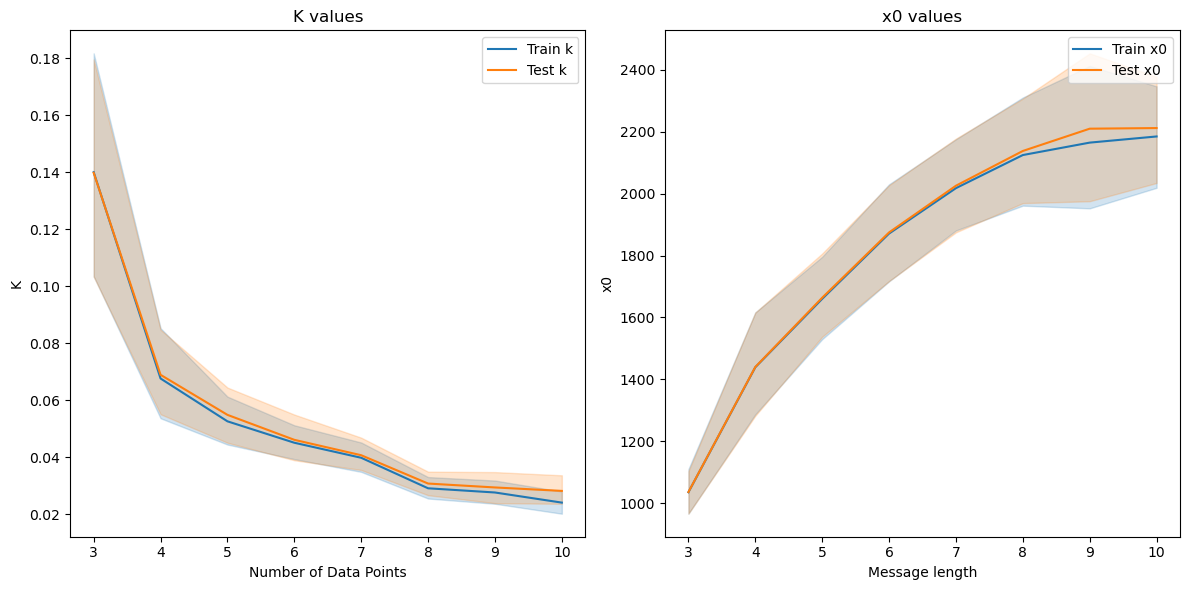

In [13]:
# Modifying prior code, such that it checks against message length rather than number of samples.

# Modifying the above code, such that the training process only halts after 98% or so accuracy is reached
# Using a hard stop to avoid runtime errors, and some later lag to get additional data, 
# this should make the code for efficient

# Find sigmoid fit parameters on average (weighted by covariance error?)

num_repeats = 30

n_tasks = 3
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
#len_message_list = np.arange(3,11,1,dtype=int)  # Maximum integer value in the associated integer list
len_message_list = [10, 9, 8, 7, 6, 5, 4, 3]
num_samples = 1500 #possibly not enough. Originally 1500
samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
#input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32

max_num_epochs = 10000 # Probably far too high. Originally 10,000
epoch_lag = 100 # Not very far at all. Should be just enough to get the grok though. This should be increased I think
accuracy_lim = 0.90

test_frac = 0.2 # proportion of dataset reserved for validation
num_layers = 6
hidden_size = 32

# For sigmoid fits. At the moment arranged for constrained_sigmoid
train_sig_params = np.zeros((len(len_message_list), 2, num_repeats))
test_sig_params = np.zeros((len(len_message_list), 2, num_repeats))

#plt.close()
#fig, axs = plt.subplots(len(hidden_size_list), 2, figsize=(10, len(hidden_size_list)*5))


for index, len_message in enumerate(len_message_list):
    print(f'len_message = {len_message}')
    
    for repeat_idx in tqdm(range(num_repeats)):
        tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

        [data, value] = generate_dataset(tasks_dict, num_samples)

        # Create a dataframe for training
        df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

        # Split the data into training and test sets
        train_df, test_df = train_test_split(df, test_size=test_frac)

        # Create instances of the neural network
        input_size = len_taskcode + len_message
        model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

        # Define loss function and optimizer (same as before)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Create DataLoaders for the training and test data
        train_dataset = CustomDataset(train_df)
        test_dataset = CustomDataset(test_df)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        train_loss_list = np.empty(max_num_epochs)
        test_loss_list = np.empty(max_num_epochs)

        train_accuracy_list = np.empty(max_num_epochs)
        test_accuracy_list = np.empty(max_num_epochs)

        accuracy_array = np.zeros((n_tasks, max_num_epochs)) # such that each row is the accuracy for that specific task over all epochs

        # Train the model
        lag_counter = 0
        epoch = 0
        #pbar = tqdm(total=max_num_epochs)
        while lag_counter <= epoch_lag and epoch < max_num_epochs:
            
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            model.train()
            

            for inputs, labels in train_loader:
                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels.unsqueeze(1))

                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                train_correct += (predictions == labels).sum().item()
                train_total += labels.size(0)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

            # Calculate average train loss
            train_loss = train_loss / len(train_dataset)
            # Calculate average train accuracy
            train_accuracy = train_correct / train_total

            # Evaluate the model on the test set
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    # Compute predictions
                    predictions = (outputs >= 0.5).squeeze().long()

                    # Compute accuracy
                    test_correct += (predictions == labels).sum().item()
                    test_total += labels.size(0)

                    loss = criterion(outputs, labels.unsqueeze(1))
                    test_loss += loss.item() * inputs.size(0)

                # Calculate average test loss
                test_loss = test_loss / len(test_dataset)

            # Calculate average test accuracy
            test_accuracy = test_correct / test_total
            
            if test_accuracy > accuracy_lim:
                lag_counter += 1
            # Update the loss lists
            train_loss_list[epoch] = train_loss
            test_loss_list[epoch] = test_loss

            train_accuracy_list[epoch] = train_accuracy
            test_accuracy_list[epoch] = test_accuracy
            
            epoch += 1
            if epoch % 100 == 0:
                print(f'Repeat: {repeat_idx} - Epoch: {epoch} - Test Accuracy: {test_accuracy}')
            #pbar.update(1)
        #pbar.close() # dealing with progress bar
        num_epochs = epoch # redefining the maximum extent of the x axis in plots to however far the algorithm went.
        
        # truncating loss and accuracy data, removing excess zeros at the ends
        train_loss_list = train_loss_list[0:epoch]
        test_loss_list = test_loss_list[0:epoch]
        train_accuracy_list = train_accuracy_list[0:epoch]
        test_accuracy_list = test_accuracy_list[0:epoch]
        
        if repeat_idx == 0: 
            # Create subplots with 1 row and 2 columns
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))

            pytorch_total_params = sum(p.numel() for p in model.parameters())
            #print(f"Total model parameters = {pytorch_total_params}")
            
            # Plot the training and test losses on the first subplot
            axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
            axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Loss')
            axs[0].legend()
            axs[0].set_title(f'Loss for Message Length = {len_message}')  # Set title for the first subplot

            # Plot the training and test accuracies on the second subplot
            axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
            axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Accuracy')
            axs[1].legend()
            axs[1].set_title(f'Accuracy for Message Length = {len_message}')

            plt.suptitle(f'Learning curves for Message Length = {len_message}', y=0.98)
            plt.show()
        #pbar.close()
        # Used when constrained sigmoid function is being fit
        epoch_list = range(1, num_epochs+1)
        try:
            p0_train = [np.median(epoch_list) , 1] # this is an mandatory initial guess
            popt_train, pcov_train = curve_fit(constrained_sigmoid, epoch_list, train_accuracy_list, p0_train, method='dogbox')
            p0_test = [np.median(epoch_list) , 1]
            popt_test, pcov_test = curve_fit(constrained_sigmoid, epoch_list, test_accuracy_list, p0_test, method='dogbox')

            train_accuracy_fit = constrained_sigmoid(epoch_list, popt_train[0], popt_train[1])
            test_accuracy_fit = constrained_sigmoid(epoch_list, popt_test[0], popt_test[1])

            #plt.plot(epoch_list, train_accuracy_fit, label='Sigmoid fit - train data')
            #plt.plot(epoch_list, test_accuracy_fit, label='Sigmoid fit - test data')
            #plt.legend()
            #plt.show()

            train_sig_params[index, :, repeat_idx] = popt_train
            test_sig_params[index, :, repeat_idx] = popt_test

        except RuntimeError:
            print('Failed to find optimal solution')
    
print('train_sig_params = ', train_sig_params) # x0, k
print('test_sig_params = ', test_sig_params) # x0, k

train_sig_params_copy = train_sig_params
test_sig_params_copy = test_sig_params

# COPIED: This code is currently identical to code in an above cell, copied here for convenience.

train_sig_params[ train_sig_params==0.0 ] = np.nan
test_sig_params[ test_sig_params==0.0 ] = np.nan

train_sig_params_x0 = train_sig_params[:, 0, :].flatten()
train_sig_params_k = train_sig_params[:, 1, :].flatten()

test_sig_params_x0 = test_sig_params[:, 0, :].flatten()
test_sig_params_k = test_sig_params[:, 1, :].flatten()

#num_samples_list = np.arange(1000, 2000, 10)
repeated_len_message_list = np.repeat(len_message_list, repeats = num_repeats)
#print(num_samples_list)
#print(repeated_num_samples_list)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

train_sig_params_k_df = pd.DataFrame({'repeated_len_message_list': repeated_len_message_list, 'train_sig_params_k': train_sig_params_k})
test_sig_params_k_df = pd.DataFrame({'repeated_len_message_list': repeated_len_message_list, 'test_sig_params_k': test_sig_params_k})

# Plot train values
sns.lineplot(data=train_sig_params_k_df, x='repeated_len_message_list', y='train_sig_params_k', ax=axs[0], errorbar=('ci', 95), label='Train k')
sns.lineplot(data=test_sig_params_k_df, x='repeated_len_message_list', y='test_sig_params_k', ax=axs[0], errorbar=('ci', 95), label='Test k')

#sns.lineplot(data=train_sig_params_k, ax=axs[0], errorbar=('ci', 95), label='Train k'))
#sns.lineplot(data=test_sig_params_k, ax=axs[0], errorbar=('ci', 95), label='Test k')

#axs[0].set_xticks(range(len(num_samples_list)))
#axs[0].set_xticklabels(num_samples_list)
axs[0].set_xlabel('Message Length')
axs[0].set_ylabel('K')
axs[0].set_title('K values')
axs[0].legend()

train_sig_params_x0_df = pd.DataFrame({'repeated_len_message_list': repeated_len_message_list, 'train_sig_params_x0': train_sig_params_x0})
test_sig_params_x0_df = pd.DataFrame({'repeated_len_message_list': repeated_len_message_list, 'test_sig_params_x0': test_sig_params_x0})

# Plot test values
sns.lineplot(data=train_sig_params_x0_df, x='repeated_len_message_list', y='train_sig_params_x0', ax=axs[1], errorbar=('ci', 95), label='Train x0')
sns.lineplot(data=test_sig_params_x0_df, x='repeated_len_message_list', y='test_sig_params_x0', ax=axs[1], errorbar=('ci', 95), label='Test x0')

#sns.lineplot(data=train_sig_params_x0, ax=axs[1], errorbar=('ci', 95), label='Train x0')
#sns.lineplot(data=test_sig_params_x0, ax=axs[1], errorbar=('ci', 95), label='Test x0')

#axs[1].set_xticks(range(len(num_samples_list)))
#axs[1].set_xticklabels(num_samples_list)
axs[1].set_xlabel('Message Length')
axs[1].set_ylabel('x0')
axs[1].set_title('x0 values')
axs[1].legend()

# Adjust the layout of subplots
plt.tight_layout()

# Display the plot
plt.show()

In [20]:
'''
# This code calculates the grok gap using the above parameters. This is more of a proof of concept than anything else.

# Calculating the grok gap from sigmoid parameters

def inv_constrained_sig(k, x0, sigma):
    x = -1/k * np.log(1 / (2 * sigma - 1) - 1) + x0
    return x

def grok_gap_squared(params1, params2): 
    # params1 is the test and params2 is the train. Not relevant now, might matter when other complex measures are used
    print(f'params1 = ', params1)
    k1, x01 = params1
    k2, x02 = params2
    deltax = x02 - x01
    if k1==0 or k2==0:
        return 0
    deltainvk = 1/k1 - 1/k2
    gap = 0.5 * np.power(deltax, 2) + np.power(np.pi, 2)/6 * np.power(deltainvk, 2)
    return gap

# Each list entry is a pair of x0 then k
# Designed to deal with lists of the form of train_sig_params and test_sig_params
def find_gaps(train_sig_params, test_sig_params):
    if len(train_sig_params) != len(test_sig_params):
        print("Error: Train and test parameter lists must be of the same length.")
        return
    grok_gap_list = np.zeros(len(train_sig_params))
    for i in range(len(train_sig_params)):
        train_pair = train_sig_params[i]
        test_pair = test_sig_params[i]
        gap = grok_gap_squared(test_pair, train_pair)
        grok_gap_list[i] = gap
    return grok_gap_list

#print(train_sig_params)
#print(test_sig_params)

train_sig_params_x0 = train_sig_params[:, 0, :].flatten()
train_sig_params_k = train_sig_params[:, 1, :].flatten()

test_sig_params_x0 = test_sig_params[:, 0, :].flatten()
test_sig_params_k = test_sig_params[:, 1, :].flatten()

train_sig_params_comb = [train_sig_params_k, train_sig_params_x0]
test_sig_params_comb = [test_sig_params_k, test_sig_params_x0]

#grok_gap_list = find_gaps(train_sig_params, test_sig_params)
grok_gap_list = find_gaps(train_sig_params_comb, test_sig_params_comb)

#len_message_list = [10, 9, 8, 7, 6, 5, 4, 3]
plt.plot(len_message_list, grok_gap_list)
plt.title('Train-Test Gap and Message Length')
plt.xlabel('Message Length')
plt.ylabel('Train-Test Gap')
plt.show()
'''

params1 =  [0.01496039 0.04761178 0.02080871 0.01971101 0.02358995 0.05010647
 0.01930221 0.05842124 0.01483771 0.00794116 0.03661786 0.02694116
 0.03724232 0.03041499 0.01973536 0.03563072 0.03158711 0.01635671
 0.02244695 0.04328685 0.01250078 0.03843143 0.03959549 0.00999368
 0.01357045 0.00921803 0.04344228 0.0375532  0.02422913 0.04163277
 0.06955148 0.02512536 0.04003177 0.0164297  0.03130098 0.02690141
 0.01079283 0.01534316 0.02685083 0.04045567 0.06440858 0.02016994
 0.03725502 0.04586951 0.01200348 0.04791296 0.04315745 0.02783339
 0.01521986 0.01782939 0.03013294 0.0238371  0.03247619 0.03472809
 0.01219707 0.0213786  0.03648633 0.02842112 0.02920977 0.00068164
 0.01871642 0.03719656 0.03756576 0.01816097 0.04783375 0.03091013
 0.00788847 0.02172983 0.05567745 0.03752226 0.03200353 0.01886535
 0.01433331 0.01515866 0.03002736 0.02081696 0.03185859 0.0449234
 0.03963775 0.02207627 0.04283255 0.03175593 0.03690177 0.0268225
 0.03543145 0.0176227  0.02320357 0.01993845 0.055573

ValueError: too many values to unpack (expected 2)

In [15]:
import pickle

# Save train_sig_params_copy to a file
with open('train_sig_params_copy.pkl', 'wb') as f:
    pickle.dump(train_sig_params_copy, f)

# Save hidden_size_losses to a file
with open('test_sig_params_copy.pkl', 'wb') as f:
    pickle.dump(test_sig_params_copy, f)
    
# These values took a very long time to calculate so they are worth storing
# Below are the parameters used to create this data. Just in case the above code is reworked later
'''
num_repeats = 30

n_tasks = 3
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
#len_message_list = np.arange(3,11,1,dtype=int)  # Maximum integer value in the associated integer list
len_message_list = [10, 9, 8, 7, 6, 5, 4, 3]
num_samples = 1500 #possibly not enough. Originally 1500
samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
#input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32

max_num_epochs = 10000 # Probably far too high. Originally 10,000
epoch_lag = 100 # Not very far at all. Should be just enough to get the grok though. This should be increased I think
accuracy_lim = 0.90

test_frac = 0.2 # proportion of dataset reserved for validation
num_layers = 6
hidden_size = 32
'''

'\nnum_repeats = 30\n\nn_tasks = 3\nlen_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry\nnum_checks = 3  # Length of the associated integer list for each task. Must be less than len_message\n#len_message_list = np.arange(3,11,1,dtype=int)  # Maximum integer value in the associated integer list\nlen_message_list = [10, 9, 8, 7, 6, 5, 4, 3]\nnum_samples = 1500 #possibly not enough. Originally 1500\nsamples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance\n# Define hyperparameters\n#input_size = len_taskcode + len_message\noutput_size = 1\nlearning_rate = 0.005\nbatch_size = 32\n\nmax_num_epochs = 10000 # Probably far too high. Originally 10,000\nepoch_lag = 100 # Not very far at all. Should be just enough to get the grok though. This should be increased I think\naccuracy_lim = 0.90\n\ntest_frac = 0.2 # proportion of dataset reserved for validation\nnum_layers = 6\nhidden_size = 32\n'

C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\notebook_654\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


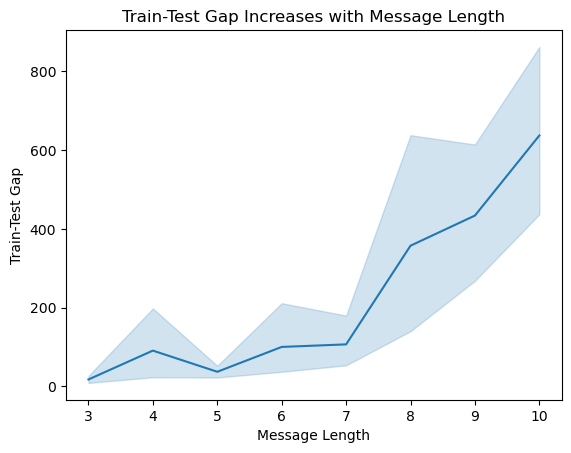

In [27]:
# Calculating the grok gap using above data, with repeats

train_sig_params_x0 = train_sig_params[:, 0, :].flatten()
train_sig_params_k = train_sig_params[:, 1, :].flatten()

test_sig_params_x0 = test_sig_params[:, 0, :].flatten()
test_sig_params_k = test_sig_params[:, 1, :].flatten()

def grok_gap_squared(params1, params2): 
    # params1 is the test and params2 is the train. Not relevant now, might matter when other complex measures are used
    k1, x01 = params1
    k2, x02 = params2
    deltax = x02 - x01
    if k1==0 or k2==0:
        return 0
    deltainvk = 1/k1 - 1/k2
    gap = 0.5 * np.power(deltax, 2) + np.power(np.pi, 2)/6 * np.power(deltainvk, 2)
    return gap

def find_grok_gaps(train_sig_params_x0, train_sig_params_k, test_sig_params_x0, test_sig_params_k):
    gap_list = []
    for index in range(len(train_sig_params_x0)): #assumes all input arrays are of equal length
        params1 = [test_sig_params_k[index], test_sig_params_x0[index]]
        params2 = [train_sig_params_k[index], train_sig_params_x0[index]]
        gap = grok_gap_squared(params1, params2)
        gap_list.append(gap)
    for index, gap in enumerate(gap_list):
        if gap >= 5000:
            gap_list[index] = 0
    return gap_list
    
repeated_len_message_list = np.repeat(len_message_list, repeats = num_repeats)
    
gap_list = find_grok_gaps(train_sig_params_x0, train_sig_params_k, test_sig_params_x0, test_sig_params_k)

gap_df = pd.DataFrame({'repeated_len_message_list': repeated_len_message_list, 'gap_list': gap_list})

sns.lineplot(data=gap_df, x='repeated_len_message_list', y='gap_list', errorbar=('ci', 95), label='Train-Test Gap')
plt.xlabel('Message Length')
plt.ylabel('Train-Test Gap')
plt.title('Train-Test Gap Increases with Message Length')
plt.legend('', frameon=False)
plt.show()